# **FGV EESP**

- ## Dados Econômicos - Brasil
---



### **Bibliotecas**

In [ ]:
# Obter os dados do SGS do Banco Central do Brasil
install.packages("rbcb")

# Gráficos de sazonalidade
install.packages("forecast")

# Testes de raiz unitária
install.packages("urca")

# Estatística descritiva
install.packages("stargazer")

# Painéis com gráficos
install.packages("gridExtra")

# Modelo VAR
install.packages("vars")

# Modelo VECM
install.packages("tsDyn")

In [ ]:
library(dplyr)
library(forecast)
library(ggplot2)
library(gridExtra)
library(httr)
library(jsonlite)
library(lubridate)
library(readxl)
library(rbcb)
library(stargazer)
library(tsDyn)
library(urca)
library(vars)
library(tidyverse)
library(zoo)

### **Dados**

In [ ]:
# Referência: https://olinda.bcb.gov.br/olinda/servico/Expectativas/versao/v1/aplicacao#!/recursos/ExpectativasMercadoInflacao12Meses#eyJmb3JtdWxhcmlvIjp7IiRmb3JtYXQiOiJqc29uIiwiJHRvcCI6MTAwLCIkZmlsdGVyIjoiBDkEIGVxIDAgYW5kIAQyBCBlcSAnUycgYW5kIAQwBCBlcSAnSVBDQScgYW5kIAQxBCBnZSAnMjAwNi0wMS0wMScgYW5kIAQxBCBsZSAnMjAyMy0wNi0zMCciLCIkb3JkZXJieSI6IgQxBCBkZXNjIn0sInByb3ByaWVkYWRlcyI6WzAsMSwzLDQsNV0sInBlc3F1aXNhZG8iOnRydWUsImFjdGl2ZVRhYiI6InRhYmxlIiwiZ3JpZFN0YXRlIjp7AzADOlt7A0IDIgQwBCIsA0EDfSx7A0IDIgQxBCIsA0EDfSx7A0IDIgQzBCIsA0EDfSx7A0IDIgQzBG5hIiwDQQN9LHsDQgMiBDUEIiwDQQN9XSwDMQM6e30sAzIDOltdLAMzAzp7fSwDNAM6e30sAzUDOnt9fSwicGl2b3RPcHRpb25zIjp7A2EDOnt9LANiAzpbXSwDYwM6NTAwLANkAzpbIgQxBCJdLANlAzpbXSwDZgM6WyJN6WRpYSJdLANnAzoidmFsdWVfel90b19hIiwDaAM6InZhbHVlX3pfdG9fYSIsA2kDOnt9LANqAzp7fSwDawM6ODUsA2wDOmZhbHNlLANtAzp7fSwDbgM6e30sA28DOiJN6WRpYSIsA3ADOiJMaW5lIENoYXJ0In19

# Definir a URL da API do BCB para obter dados de Expectativa do Mercado para IPCA nos próximos 12 meses
url <- "https://olinda.bcb.gov.br/olinda/servico/Expectativas/versao/v1/odata/ExpectativasMercadoInflacao12Meses?$filter=baseCalculo%20eq%200%20and%20Suavizada%20eq%20'S'%20and%20Indicador%20eq%20'IPCA'%20and%20Data%20ge%20'2006-01-01'%20and%20Data%20le%20'2023-06-30'&$orderby=Data%20desc&$format=json&$select=Indicador,Data,Media,Mediana,DesvioPadrao"

# Realizar a consulta e ler o arquivo JSON
response <- GET(url)
data_json <- rawToChar(response$content)

# Ajuste das colunas de data
focus_inflation_expectation <- fromJSON(data_json)$value %>%
  mutate(day = ymd(Data),
         month_date = floor_date(day, unit = "month"),
         year = year(month_date),
         day_of_week = weekdays(day))

# Filtrar apenas as sextas-feiras (Referência do Boletim Focus)
fridays_only <- focus_inflation_expectation %>%
  filter(day_of_week == "Friday")

# Calcular média da coluna "Mediana" agrupada por "year" e "month_date"
result <- fridays_only %>%
  group_by(year, month_date) %>%
  summarize(market_inflation_expectation = round(mean(Mediana), 2))

# Conversão em formato de data frame e time series
df_olinda <- as.data.frame(ts(result$market_inflation_expectation, start = c(2006, 1), frequency = 12))
df_olinda <- rename(df_olinda, market_inflation_expectation = x)

# Criação de colunas para mês e ano
df_olinda$month = time(df_olinda$market_inflation_expectation)
df_olinda$month_date = result$month_date
df_olinda$year = result$year

In [4]:
# Indicador de Expectativa de Inflação dos Consumidores
# Código FGV Dados: 1416188

# Caminho do arquivo original
file_path <- "https://github.com/matheusrmorgado/inflation-expectation/raw/main/data/fgv_ibre.xlsx"

# Download do arquivo
download.file(file_path, "fgv_ibre.xlsx")

# Ler o arquivo Excel e converter em dataframe
df_fgv <- as.data.frame(read_excel("fgv_ibre.xlsx"))

# Filtrar os dados de 2006-01-01 até 2023-06-01
df_fgv <- df_fgv %>% filter(as.Date(month_date) >= as.Date("2006-01-01") & as.Date(month_date) <= as.Date("2023-06-01"))

# Conversão em formato timeseries
df_consumer <- as.data.frame(ts(df_fgv$consumer_inflation_expectation, start = c(2006, 1), frequency = 12))
df_consumer <- rename(df_consumer, consumer_inflation_expectation = x)

In [5]:
# Índice nacional de preços ao consumidor amplo acumulado em 12 meses (%)
# SGS: 13522
df_ipca <- as.data.frame(get_series(13522, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
df_ipca <- rename(df_ipca, ipca = x)

# Taxa de juros Selic acumulada no mês anualizada base 252 (% a.a.)
# SGS: 4189
df_selic <- as.data.frame(get_series(4189, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
df_selic <- rename(df_selic, selic = x)

# Índice de Atividade Econômica do Banco Central com ajuste sazonal (índice)
# SGS: 24364
df_ibc_br <- as.data.frame(get_series(24364, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
df_ibc_br <- rename(df_ibc_br, ibc_br = x)

# Dívida Líquida do Governo Geral (% PIB)
# SGS: 4536
df_gov_debt <- as.data.frame(get_series(4536, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
df_gov_debt <- rename(df_gov_debt, gov_debt = x)

# Endividamento das famílias com o SFN em relação à renda acumulada dos últimos 12 meses (%)
# SGS: 29037
df_household_debt <- as.data.frame(get_series(29037, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
df_household_debt <- rename(df_household_debt, household_debt = x)

# RNDBF restrita - valores correntes, acumulada 12 meses - R$ (bilhões)/
# SGS: 7836
df_household_income <- as.data.frame(get_series(7836, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
df_household_income <- rename(df_household_income, household_income = x)

# PIB acumulado dos últimos 12 meses - Valores correntes - R$ (bilhões)
# SGS: 4382
df_pib <- as.data.frame(get_series(4382, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
df_pib <- rename(df_pib, pib = x)

# Taxa de câmbio - Livre - Dólar americano (compra) - Fim de período - mensal (u.m.c./US$)
# SGS: 3695
df_usd_brl <- as.data.frame(get_series(3695, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
df_usd_brl <- rename(df_usd_brl, usd_brl = x)

In [6]:
# Realiza a unificação de todas as tabelas do BCB e FGV IBRE
df_public_data <- cbind(df_olinda, df_consumer, df_ipca, df_selic, df_ibc_br, df_gov_debt, df_household_debt, df_household_income, df_pib, df_usd_brl)

# Calcula o lag para IPCA e Selic
df_public_data$ipca_lag <- c(NA, df_public_data$ipca[-nrow(df_public_data)])
df_public_data$selic_lag <- c(NA, df_public_data$selic[-nrow(df_public_data)])

# Converter as colunas "ipca_lag" e "selic_lag" para séries temporais
df_public_data$ipca_lag <- ts(df_public_data$ipca_lag, start = c(2006, 1), frequency = 12)
df_public_data$selic_lag <- ts(df_public_data$selic_lag, start = c(2006, 1), frequency = 12)

# Reorganiza as colunas, colocando "month_date" e "month" nas primeiras posições
df_public_data <- df_public_data %>% dplyr::select(year, month_date, month, everything())

In [7]:
str(df_public_data)

'data.frame':	210 obs. of  15 variables:
 $ year                          : num  2006 2006 2006 2006 2006 ...
 $ month_date                    : Date, format: "2006-01-01" "2006-02-01" ...
 $ month                         : Time-Series  from 2006 to 2023: 2006 2006 2006 2006 2006 ...
 $ market_inflation_expectation  : Time-Series  from 2006 to 2023: 4.58 4.49 4.36 4.16 4.18 4.25 4.4 4.48 4.29 4.05 ...
 $ consumer_inflation_expectation: Time-Series  from 2006 to 2023: 6.9 7 6.9 6.5 6.7 6.3 6.9 6.4 6.3 5.8 ...
 $ ipca                          : Time-Series  from 2006 to 2023: 5.7 5.51 5.32 4.63 4.23 4.03 3.97 3.84 3.7 3.26 ...
 $ selic                         : Time-Series  from 2006 to 2023: 17.6 17.3 16.7 16.2 15.7 ...
 $ ibc_br                        : Time-Series  from 2006 to 2023: 114 114 113 114 116 ...
 $ gov_debt                      : Time-Series  from 2006 to 2023: 46.7 46.4 46.4 45.6 46.2 ...
 $ household_debt                : Time-Series  from 2006 to 2023: 19.9 20.1 20.4 20

In [8]:
head(df_public_data, 5)

,year,month_date,month,market_inflation_expectation,consumer_inflation_expectation,ipca,selic,ibc_br,gov_debt,household_debt,household_income,pib,usd_brl,ipca_lag,selic_lag
,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2006,2006-01-01,2006.000,4.58,6.9,5.70,17.65,113.56,46.68,19.89,167991,2190643,2.2152,NA,NA
2,2006,2006-02-01,2006.083,4.49,7.0,5.51,17.28,113.72,46.38,20.11,169200,2207671,2.1347,5.70,17.65
3,2006,2006-03-01,2006.167,4.36,6.9,5.32,16.74,113.48,46.38,20.45,166456,2225145,2.1716,5.51,17.28
4,2006,2006-04-01,2006.250,4.16,6.5,4.63,16.19,114.33,45.59,20.78,165894,2235813,2.0884,5.32,16.74
5,2006,2006-05-01,2006.333,4.18,6.7,4.23,15.70,115.65,46.21,21.07,165256,2256419,2.2997,4.63,16.19


### **Estatística Descritiva**

In [9]:
stargazer(df_public_data, digits = 2, type = "text")


Statistic                       N      Mean       St. Dev.       Min           Max     
---------------------------------------------------------------------------------------
year                           210   2,014.26       5.07        2,006         2,023    
month                          210   2,014.71       5.06       2,006.00     2,023.42   
market_inflation_expectation   210     4.85         0.93         2.96         7.01     
consumer_inflation_expectation 210     6.95         1.66         4.30         11.40    
ipca                           210     5.70         2.24         1.88         12.13    
selic                          210    10.01         3.57         1.90         17.65    
ibc_br                         210    136.16        8.61        113.48       149.30    
gov_debt                       210    45.31        10.19        30.71         66.39    
household_debt                 210    36.35         7.57        19.89         50.09    
household_income               

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


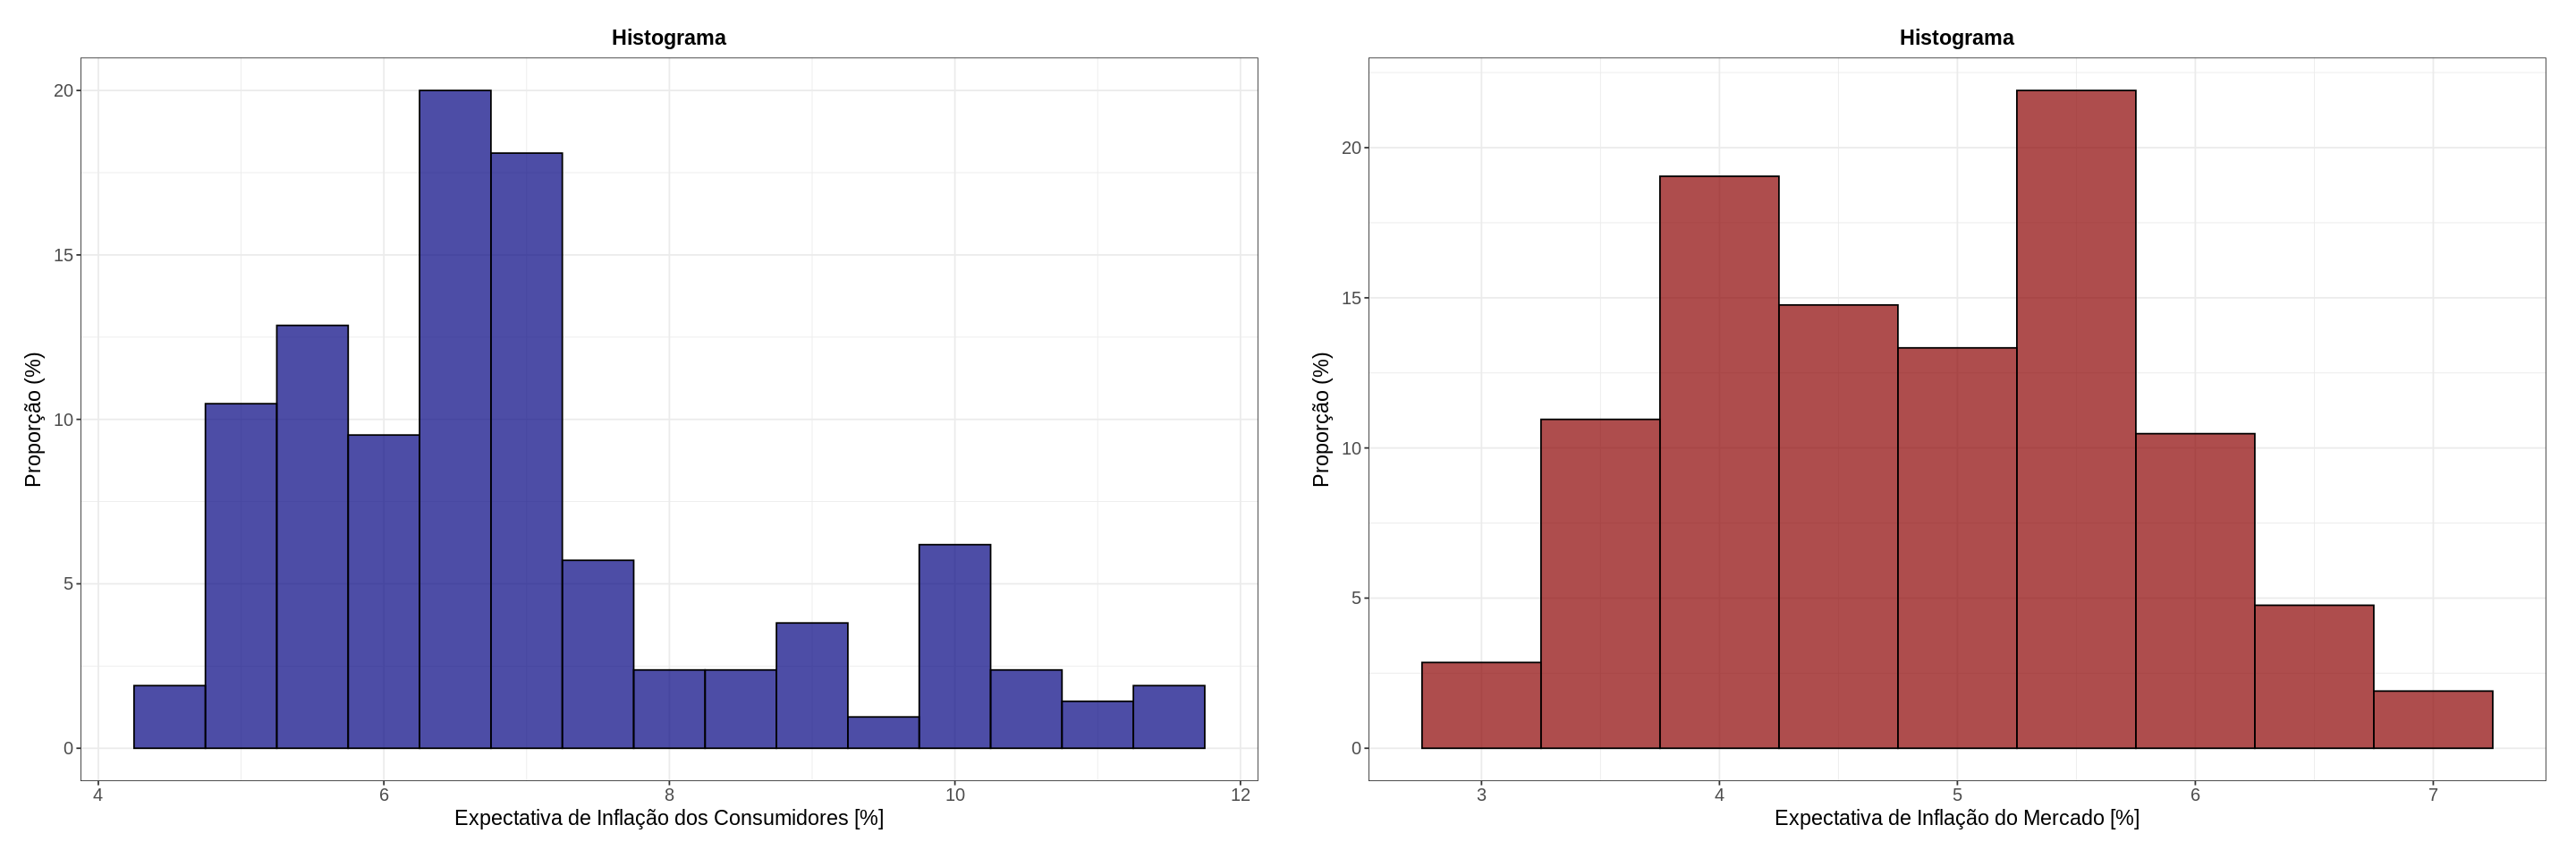

In [10]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 24, repr.plot.height = 8)

# Gráfico 1: Histograma da Expectativa de Inflação dos Consumidores
plot1 <- ggplot(df_public_data, aes(x = consumer_inflation_expectation, y = 100 * after_stat(count) / sum(after_stat(count)))) +
  geom_histogram(binwidth = 0.5, color = "black", fill = "navy", alpha = 0.7) +
  labs(x = "Expectativa de Inflação dos Consumidores [%]", y = "Proporção (%)", title = "Histograma") +
  theme_bw() +
  theme(
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),  # Ajuste o tamanho do título
    axis.text = element_text(size = 12),  # Ajuste o tamanho do texto do eixo
    axis.title.y = element_text(size = 14, vjust = 2),
    axis.title.x = element_text(size = 14),
    plot.caption = element_text(size = 10),  # Ajuste o tamanho da legenda
    plot.margin = margin(20, 20, 20, 20)
  )

# Gráfico 2: Histograma da Expectativa de Inflação do Mercado
plot2 <- ggplot(df_public_data, aes(x = market_inflation_expectation, y = 100 * after_stat(count) / sum(after_stat(count)))) +
  geom_histogram(binwidth = 0.5, color = "black", fill = "darkred", alpha = 0.7) +
  labs(x = "Expectativa de Inflação do Mercado [%]", y = "Proporção (%)", title = "Histograma") +
  theme_bw() +
  theme(
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    axis.text = element_text(size = 12),
    axis.title.y = element_text(size = 14, vjust = 2),
    axis.title.x = element_text(size = 14),
    plot.caption = element_text(size = 10),
    plot.margin = margin(20, 20, 20, 20)
  )

# Criar o painel com os gráficos lado a lado
grid.arrange(plot1, plot2, ncol = 2)


### **Visualização de Dados**

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Warning message:
“Removed 1 row containing missing values (`geom_line()`).”
Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


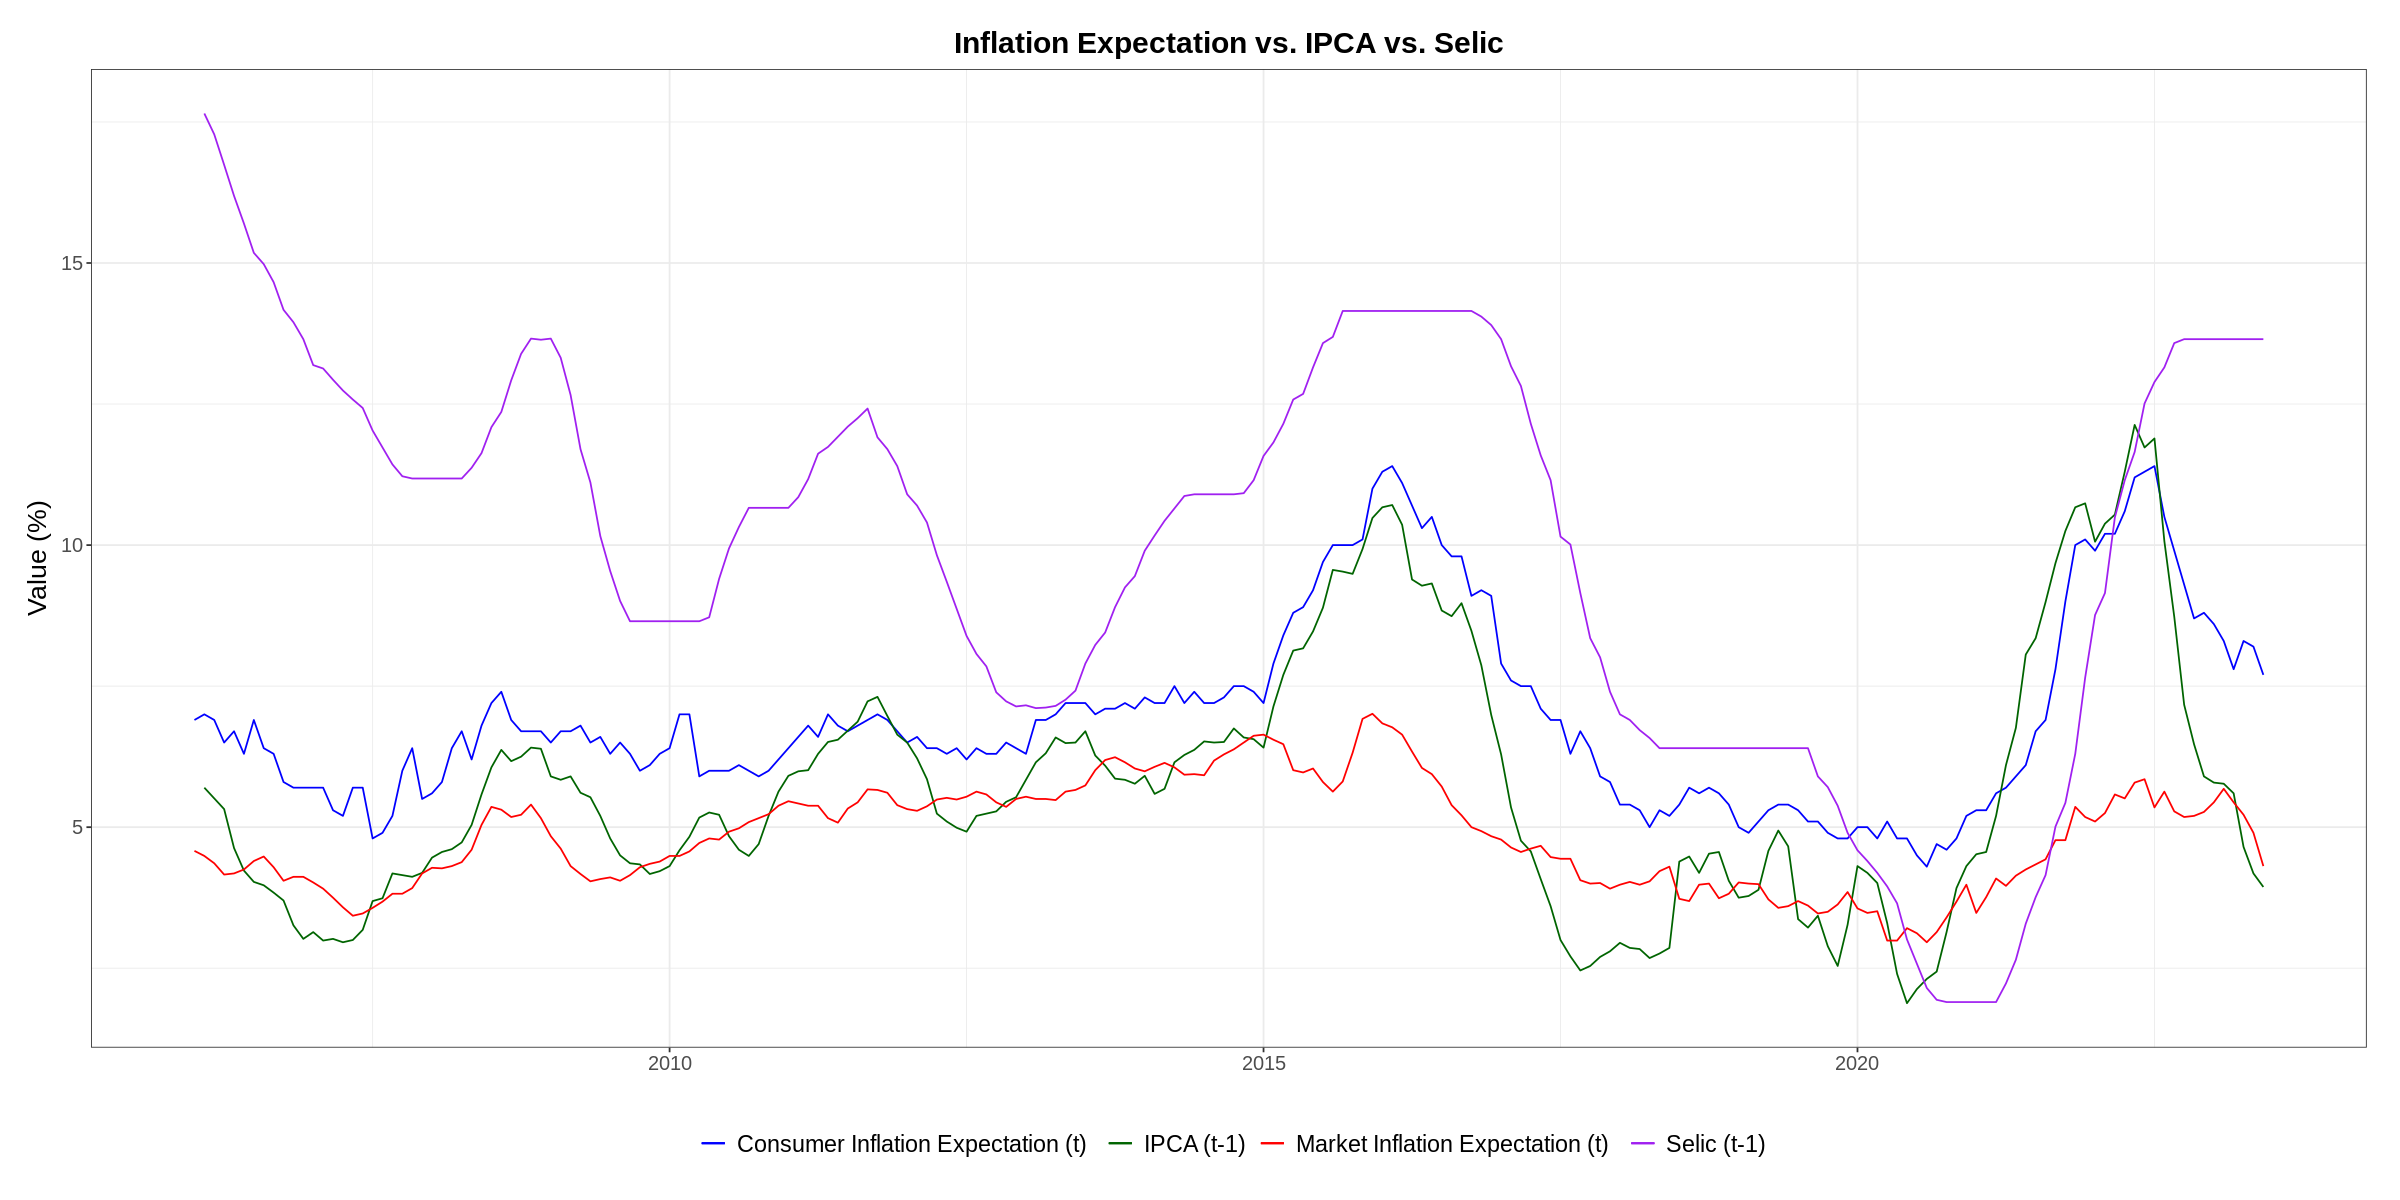

In [11]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 20, repr.plot.height = 10)

# Plotar as séries temporais de "consumer_inflation_expectation" e "market_inflation_expectation"
ggplot(df_public_data) +
  geom_line(aes(x = month, y = consumer_inflation_expectation, color = "Consumer Inflation Expectation (t)")) +
  geom_line(aes(x = month, y = ipca_lag, color = "IPCA (t-1)")) +
  geom_line(aes(x = month, y = market_inflation_expectation, color = "Market Inflation Expectation (t)")) +
  geom_line(aes(x = month, y = selic_lag, color = "Selic (t-1)")) +
  labs(x = "", y = "Value (%)", title = "Inflation Expectation vs. IPCA vs. Selic") +
  scale_color_manual(values = c("blue", "darkgreen", "red", "purple"), name = "") +
  theme_bw() +
  theme(
    legend.position = "bottom",
    legend.text = element_text(size = 14),
    legend.title = element_blank(),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    axis.text = element_text(size = 12),
    axis.title.y = element_text(size = 16, vjust = 2),
    axis.title.x = element_text(size = 14),
    plot.caption = element_text(size = 10),
    plot.margin = margin(20, 20, 20, 20)
  )

#### **Sazonalidade**

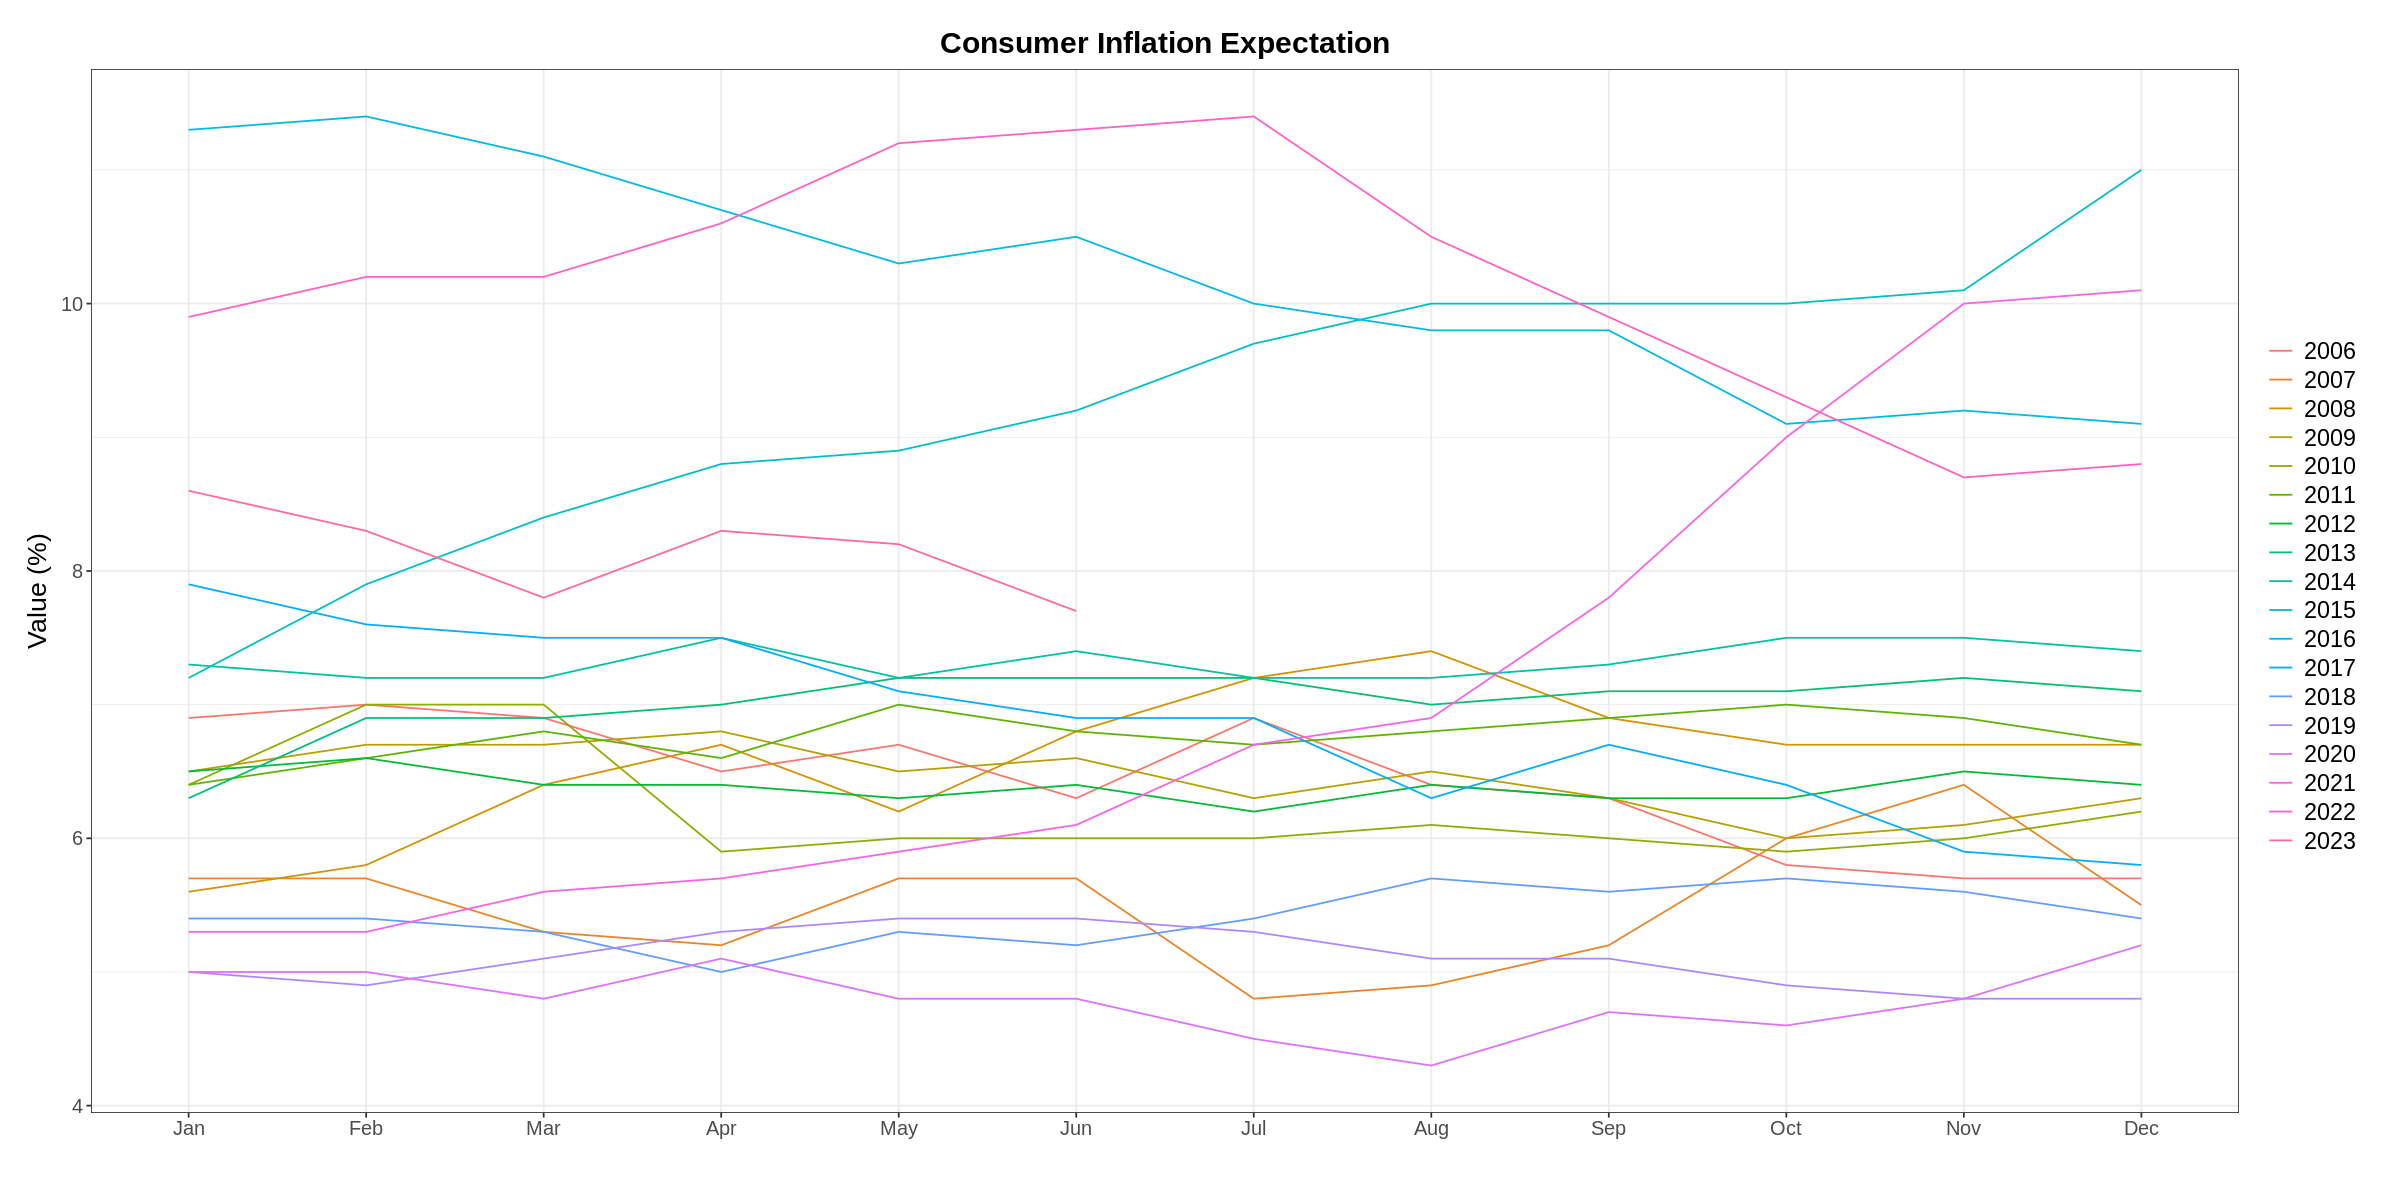

In [12]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 20, repr.plot.height = 10)

# Criar o objeto de plotagem usando ggplot
p <- ggseasonplot(df_public_data$consumer_inflation_expectation) +
  labs(x = "", y = "Value (%)", title = "Consumer Inflation Expectation") +
  theme_bw() +
  theme(
    legend.position = "right",
    legend.text = element_text(size = 14),
    legend.title = element_blank(),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    axis.text = element_text(size = 12),
    axis.title.y = element_text(size = 16, vjust = 2),
    axis.title.x = element_text(size = 14),
    plot.caption = element_text(size = 10),
    plot.margin = margin(20, 20, 20, 20)
  )

# Exibir o gráfico
print(p)

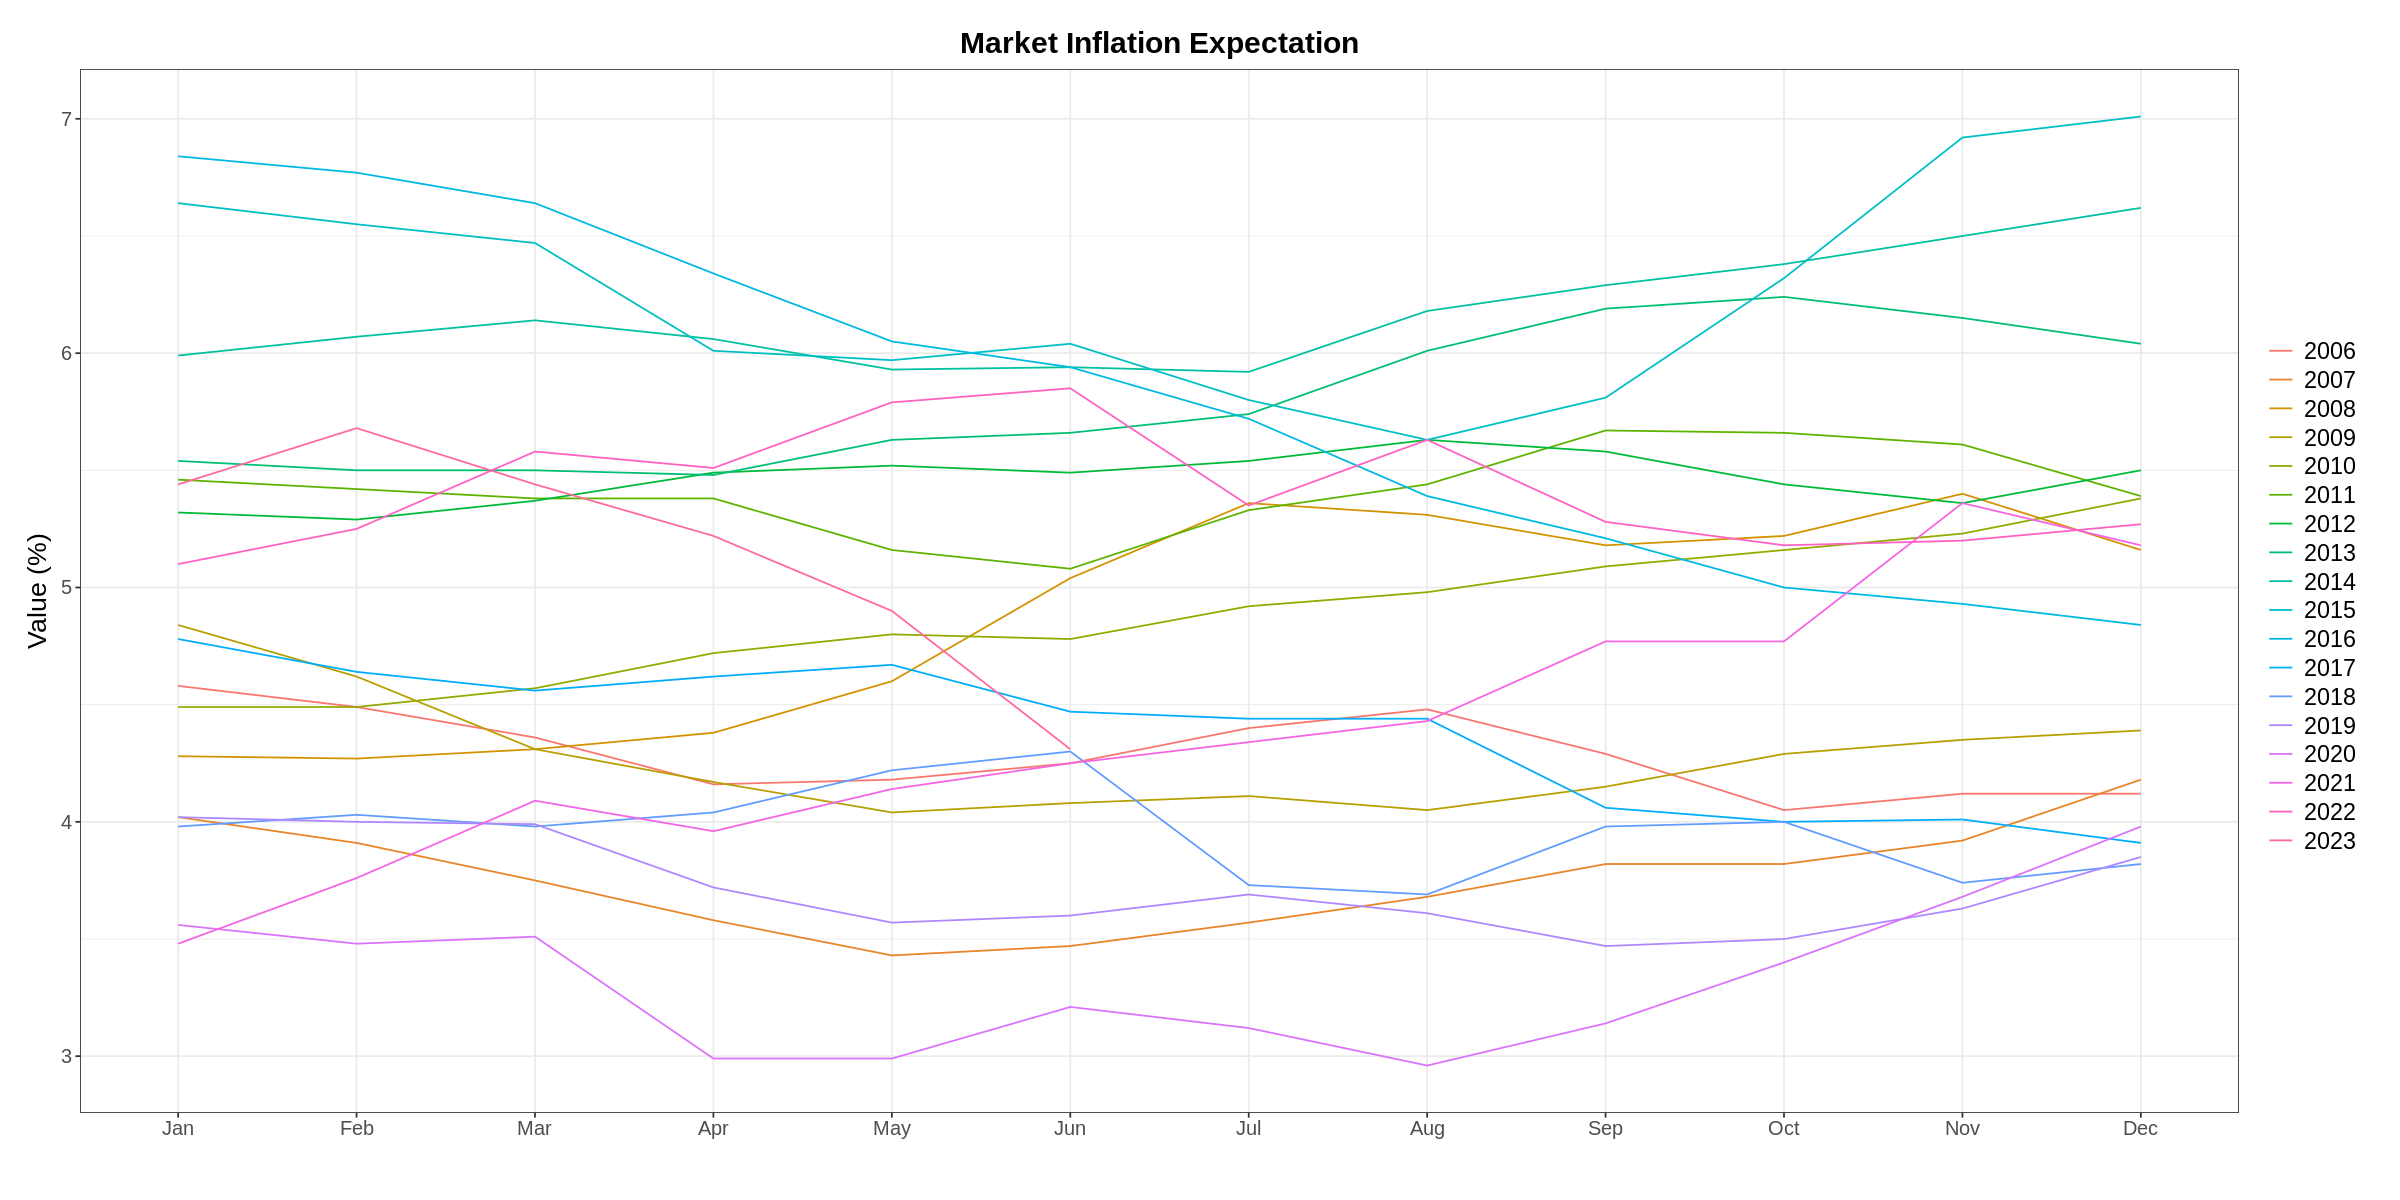

In [13]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 20, repr.plot.height = 10)

# Criar o objeto de plotagem usando ggplot
p <- ggseasonplot(df_public_data$market_inflation_expectation) +
  labs(x = "", y = "Value (%)", title = "Market Inflation Expectation") +
  theme_bw() +
  theme(
    legend.position = "right",
    legend.text = element_text(size = 14),
    legend.title = element_blank(),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    axis.text = element_text(size = 12),
    axis.title.y = element_text(size = 16, vjust = 2),
    axis.title.x = element_text(size = 14),
    plot.caption = element_text(size = 10),
    plot.margin = margin(20, 20, 20, 20)
  )

# Exibir o gráfico
print(p)

#### **Variáveis Macroeconômicas**

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of typ

TableGrob (4 x 2) "arrange": 8 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]
5 5 (3-3,1-1) arrange gtable[layout]
6 6 (3-3,2-2) arrange gtable[layout]
7 7 (4-4,1-1) arrange gtable[layout]
8 8 (4-4,2-2) arrange gtable[layout]


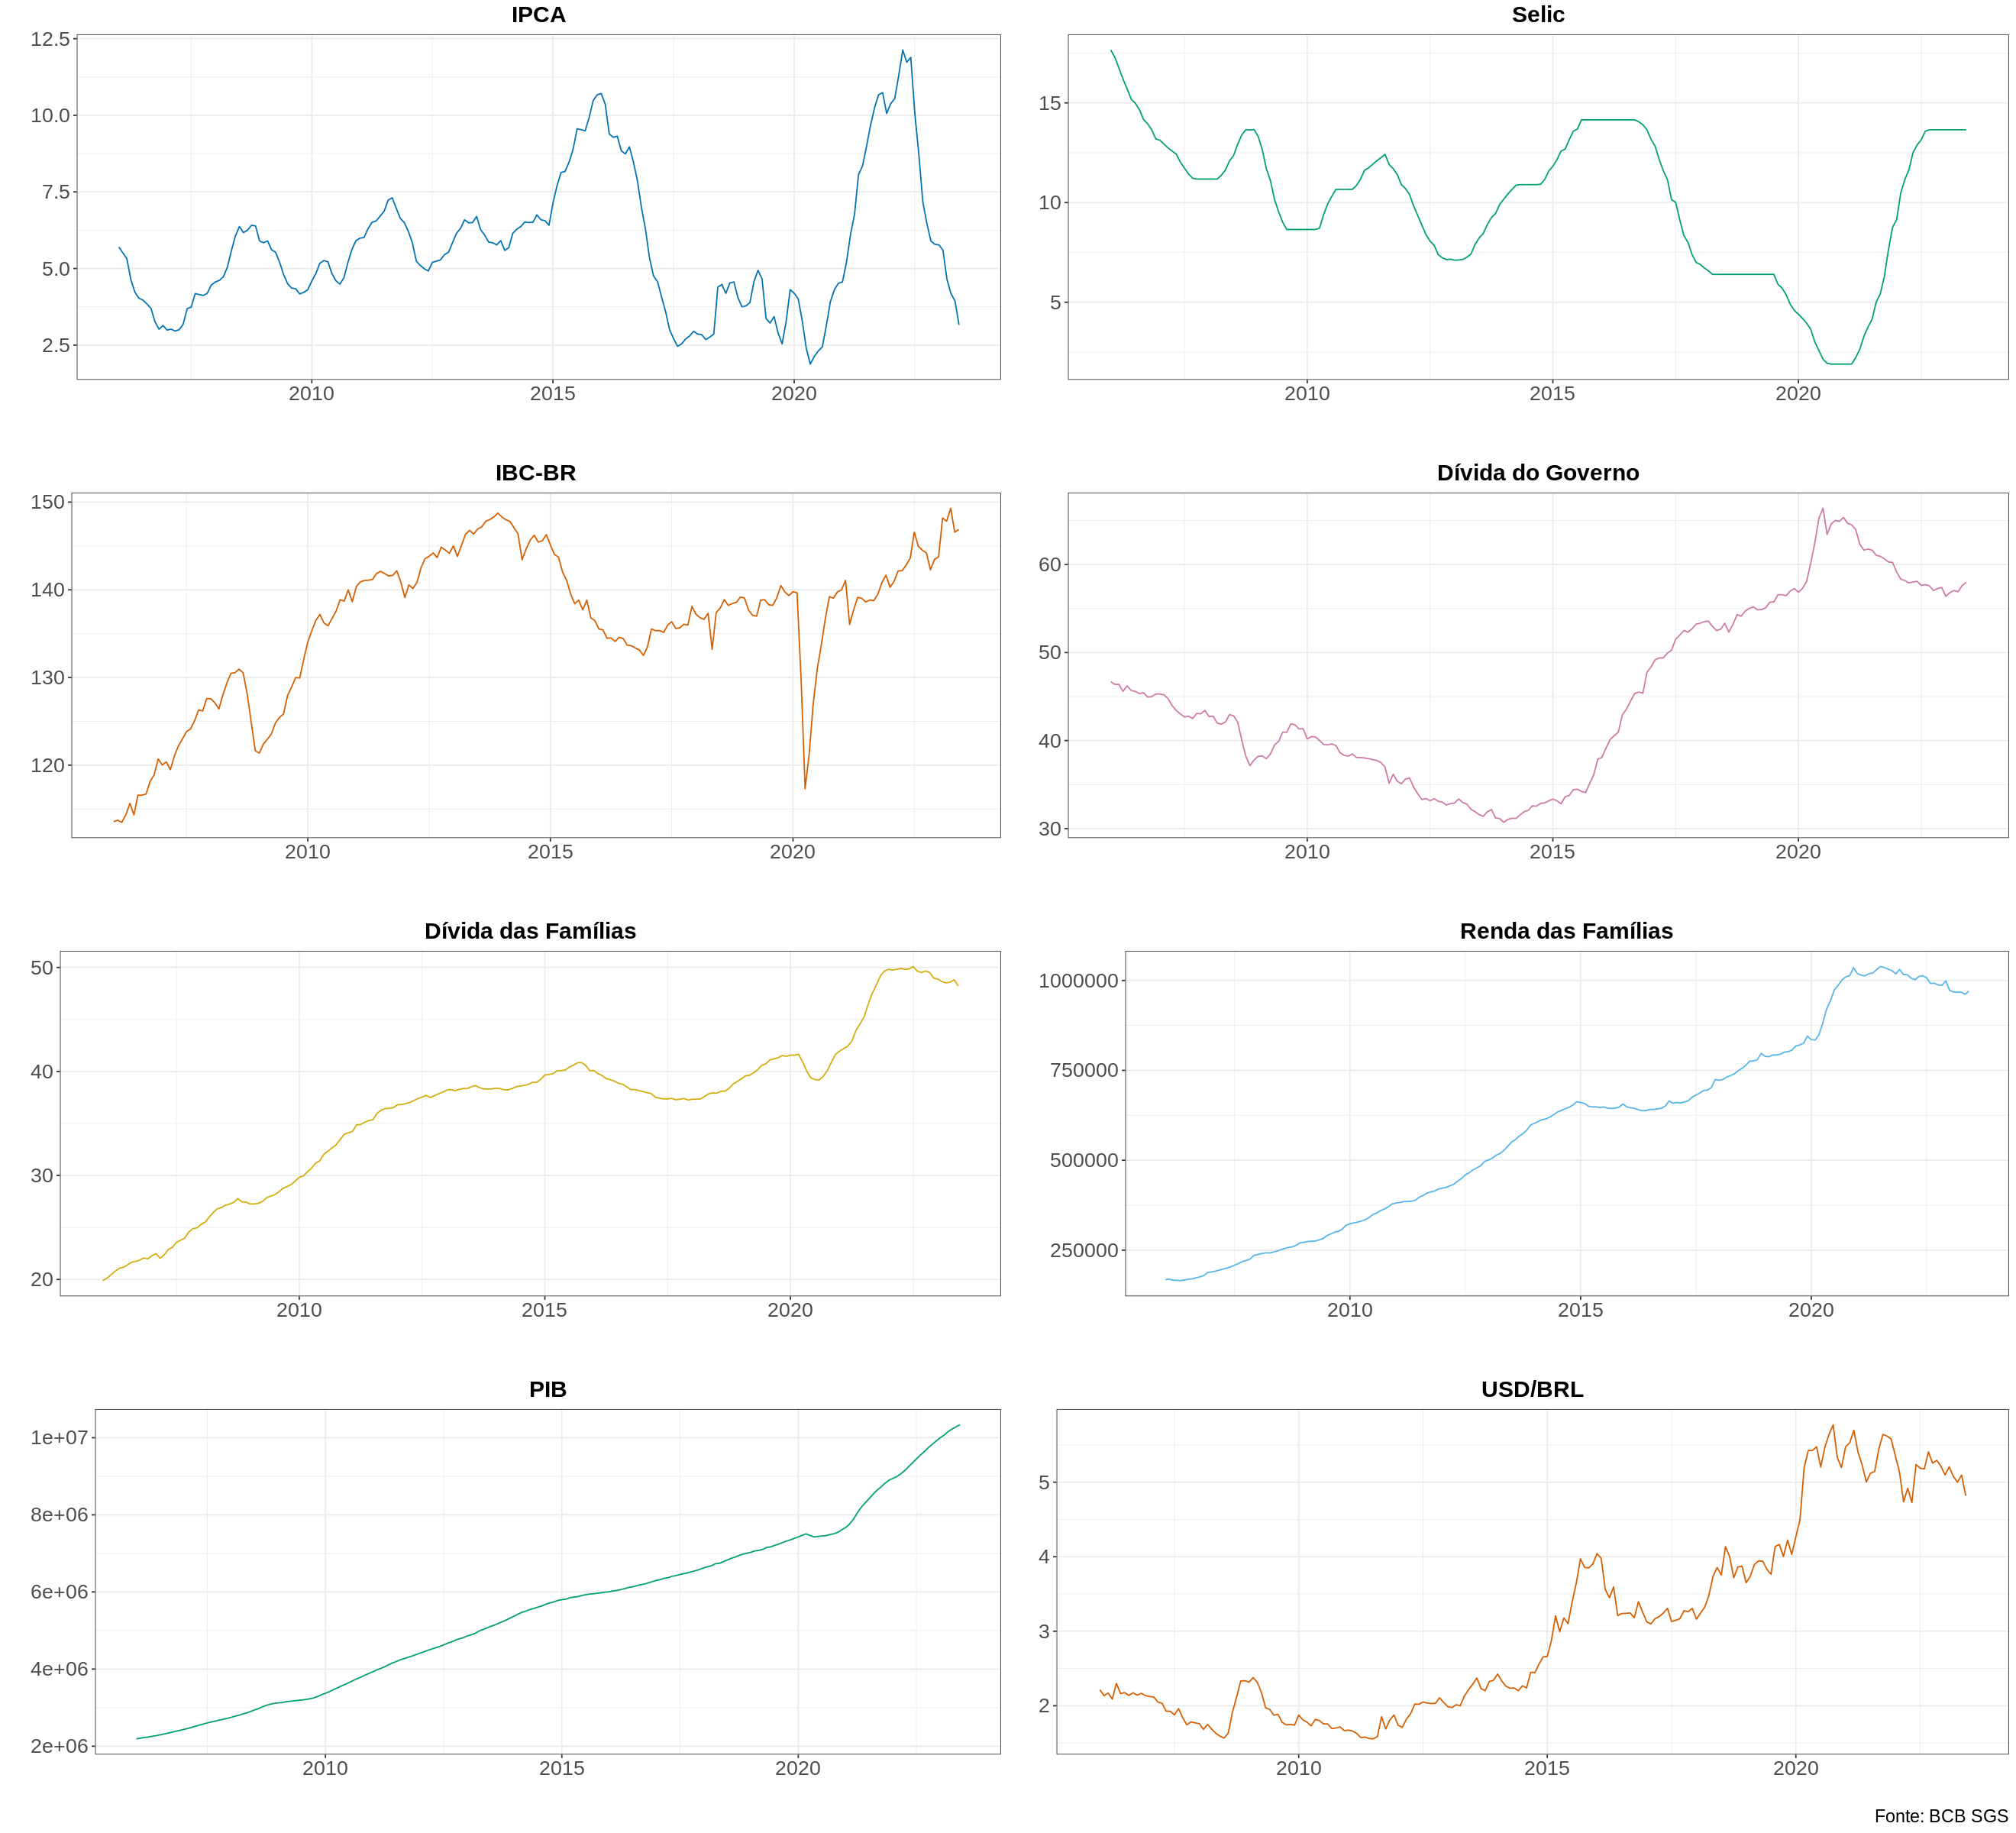

In [14]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 22, repr.plot.height = 20)  # Ajuste a altura para acomodar os 8 gráficos

# Lista de nomes das métricas
metricas <- c("ipca", "selic", "ibc_br", "gov_debt", "household_debt", "household_income", "pib", "usd_brl")

# Lista de títulos das métricas
titulos <- c("IPCA", "Selic", "IBC-BR", "Dívida do Governo", "Dívida das Famílias", "Renda das Famílias", "PIB", "USD/BRL")

# Lista de cores personalizadas
cores <- c("#0072B2", "#009E73", "#D55E00", "#CC79A7", "#D4AC0D", "#56B4E9", "#009E73", "#D55E00")

# Criar uma lista para armazenar os gráficos
graficos <- list()

# Criar os gráficos para cada métrica
for (i in 1:length(metricas)) {
  nome_metrica <- tolower(metricas[i])
  caption <- if (i == length(metricas)) "Fonte: BCB SGS" else ""  # Adicione a fonte apenas para o último gráfico
  grafico <- ggplot(df_public_data) +
    geom_line(aes(x = month, y = .data[[metricas[i]]]), color = cores[i]) +
    labs(x = "", y = "", title = titulos[i], caption = caption) +
    theme_bw() +
    theme(legend.position = "none",
          plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
          axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          plot.caption = element_text(size = 14))
  graficos[[i]] <- grafico
}

# Combinar os gráficos em um único painel
painel <- do.call(grid.arrange, c(graficos, ncol = 2))

# Apresentar o painel
print(painel)

### **Análise de Estacionariedade**

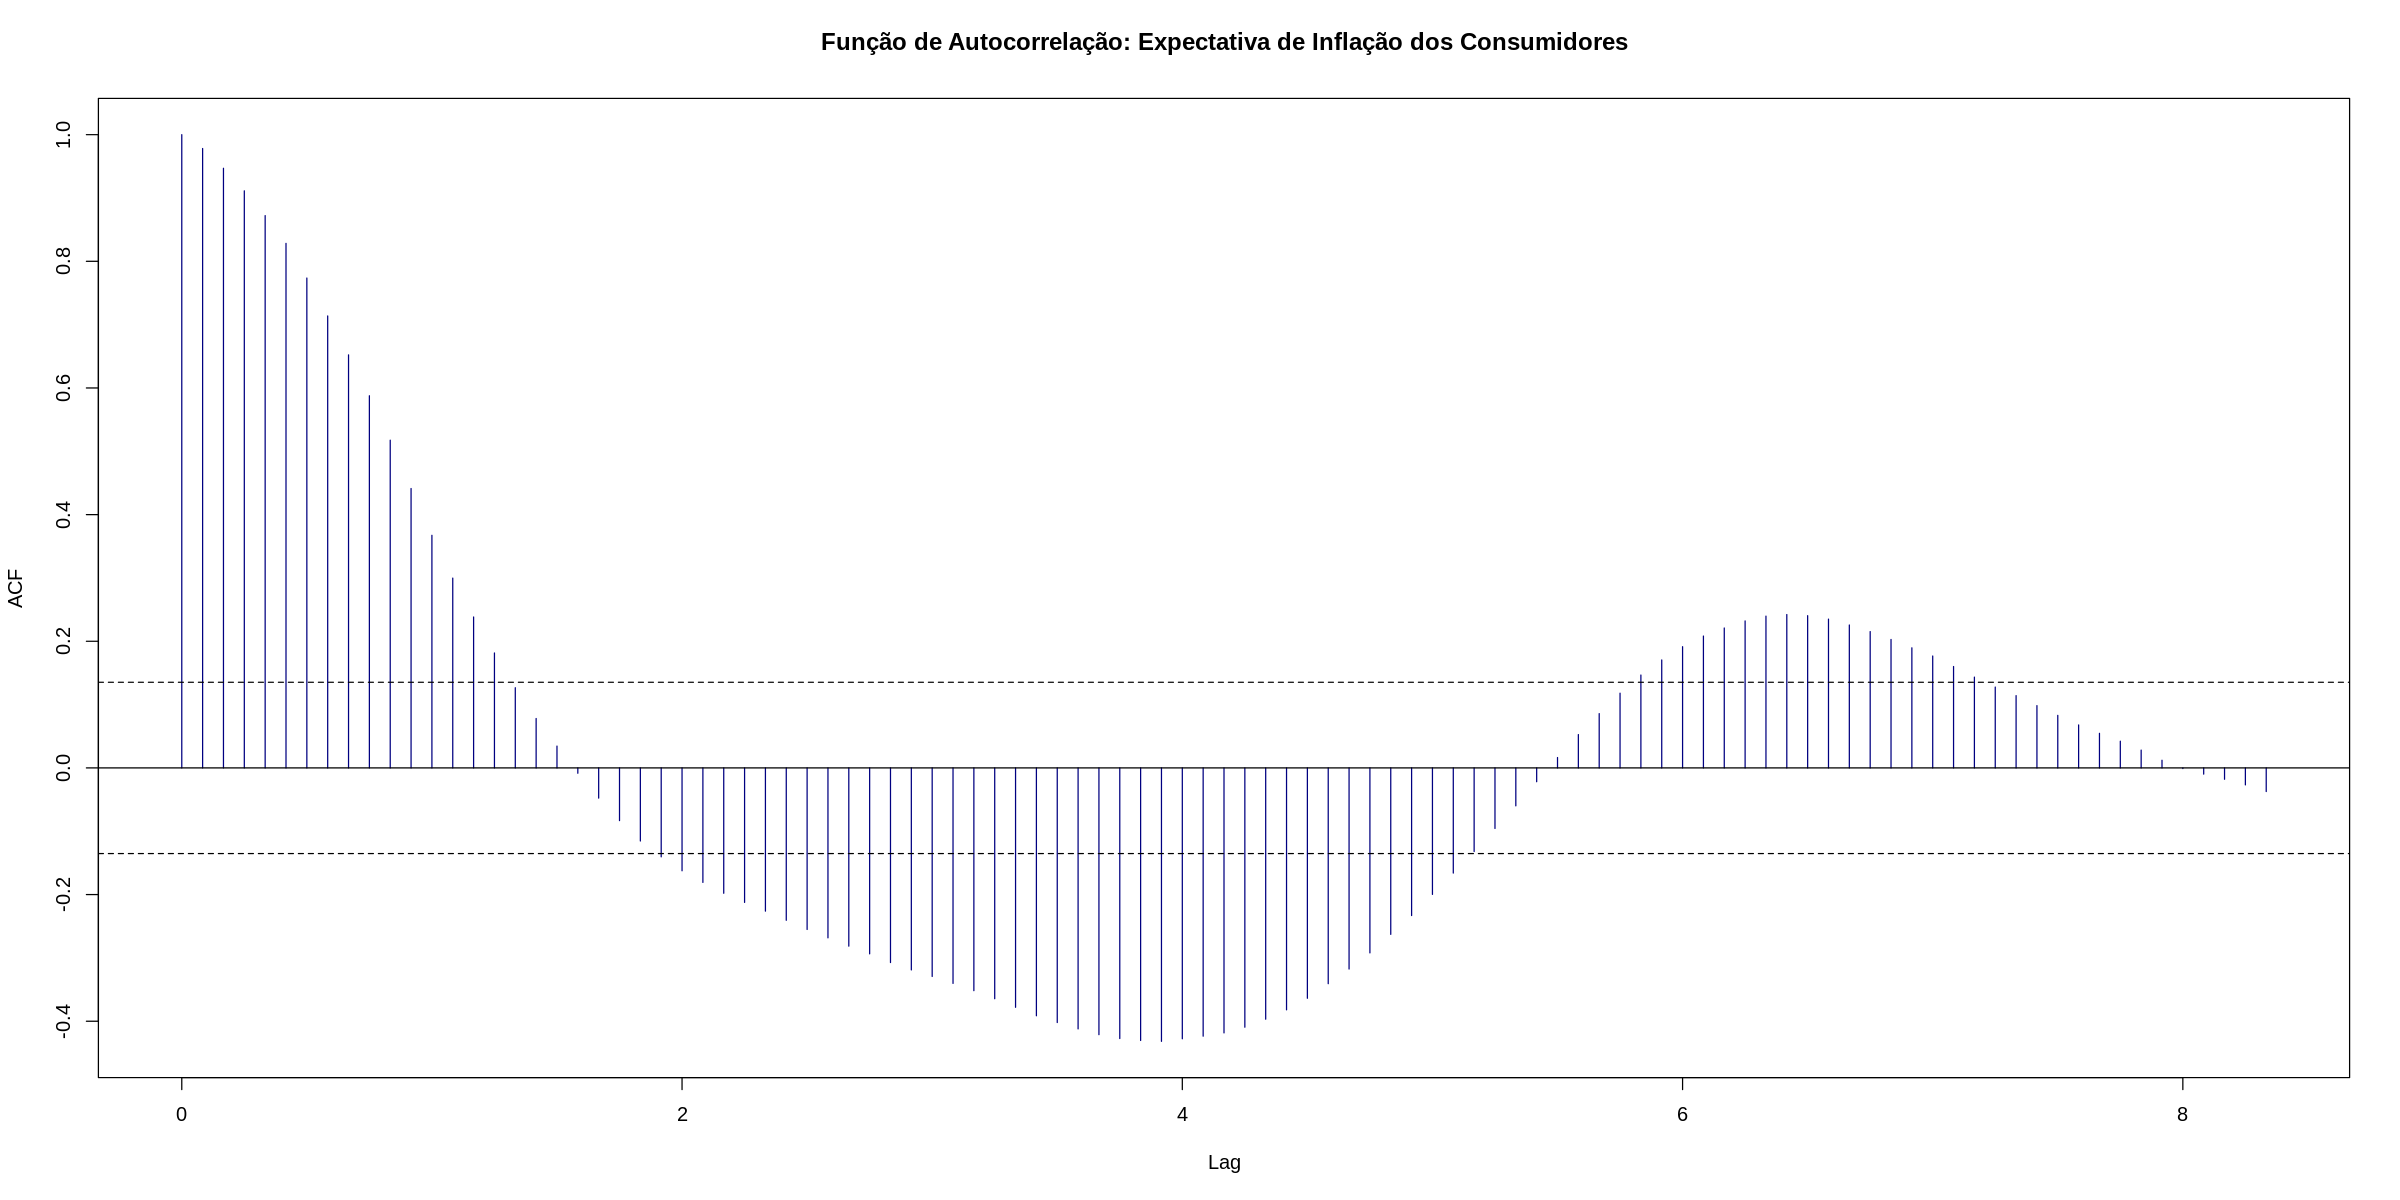

In [15]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 20, repr.plot.height = 10)

# Função de Autocorrelação
acf(df_public_data$consumer_inflation_expectation,
    main = "Função de Autocorrelação: Expectativa de Inflação dos Consumidores",
    col = "navy",
    ci.col = "black",
    lag.max = 100)

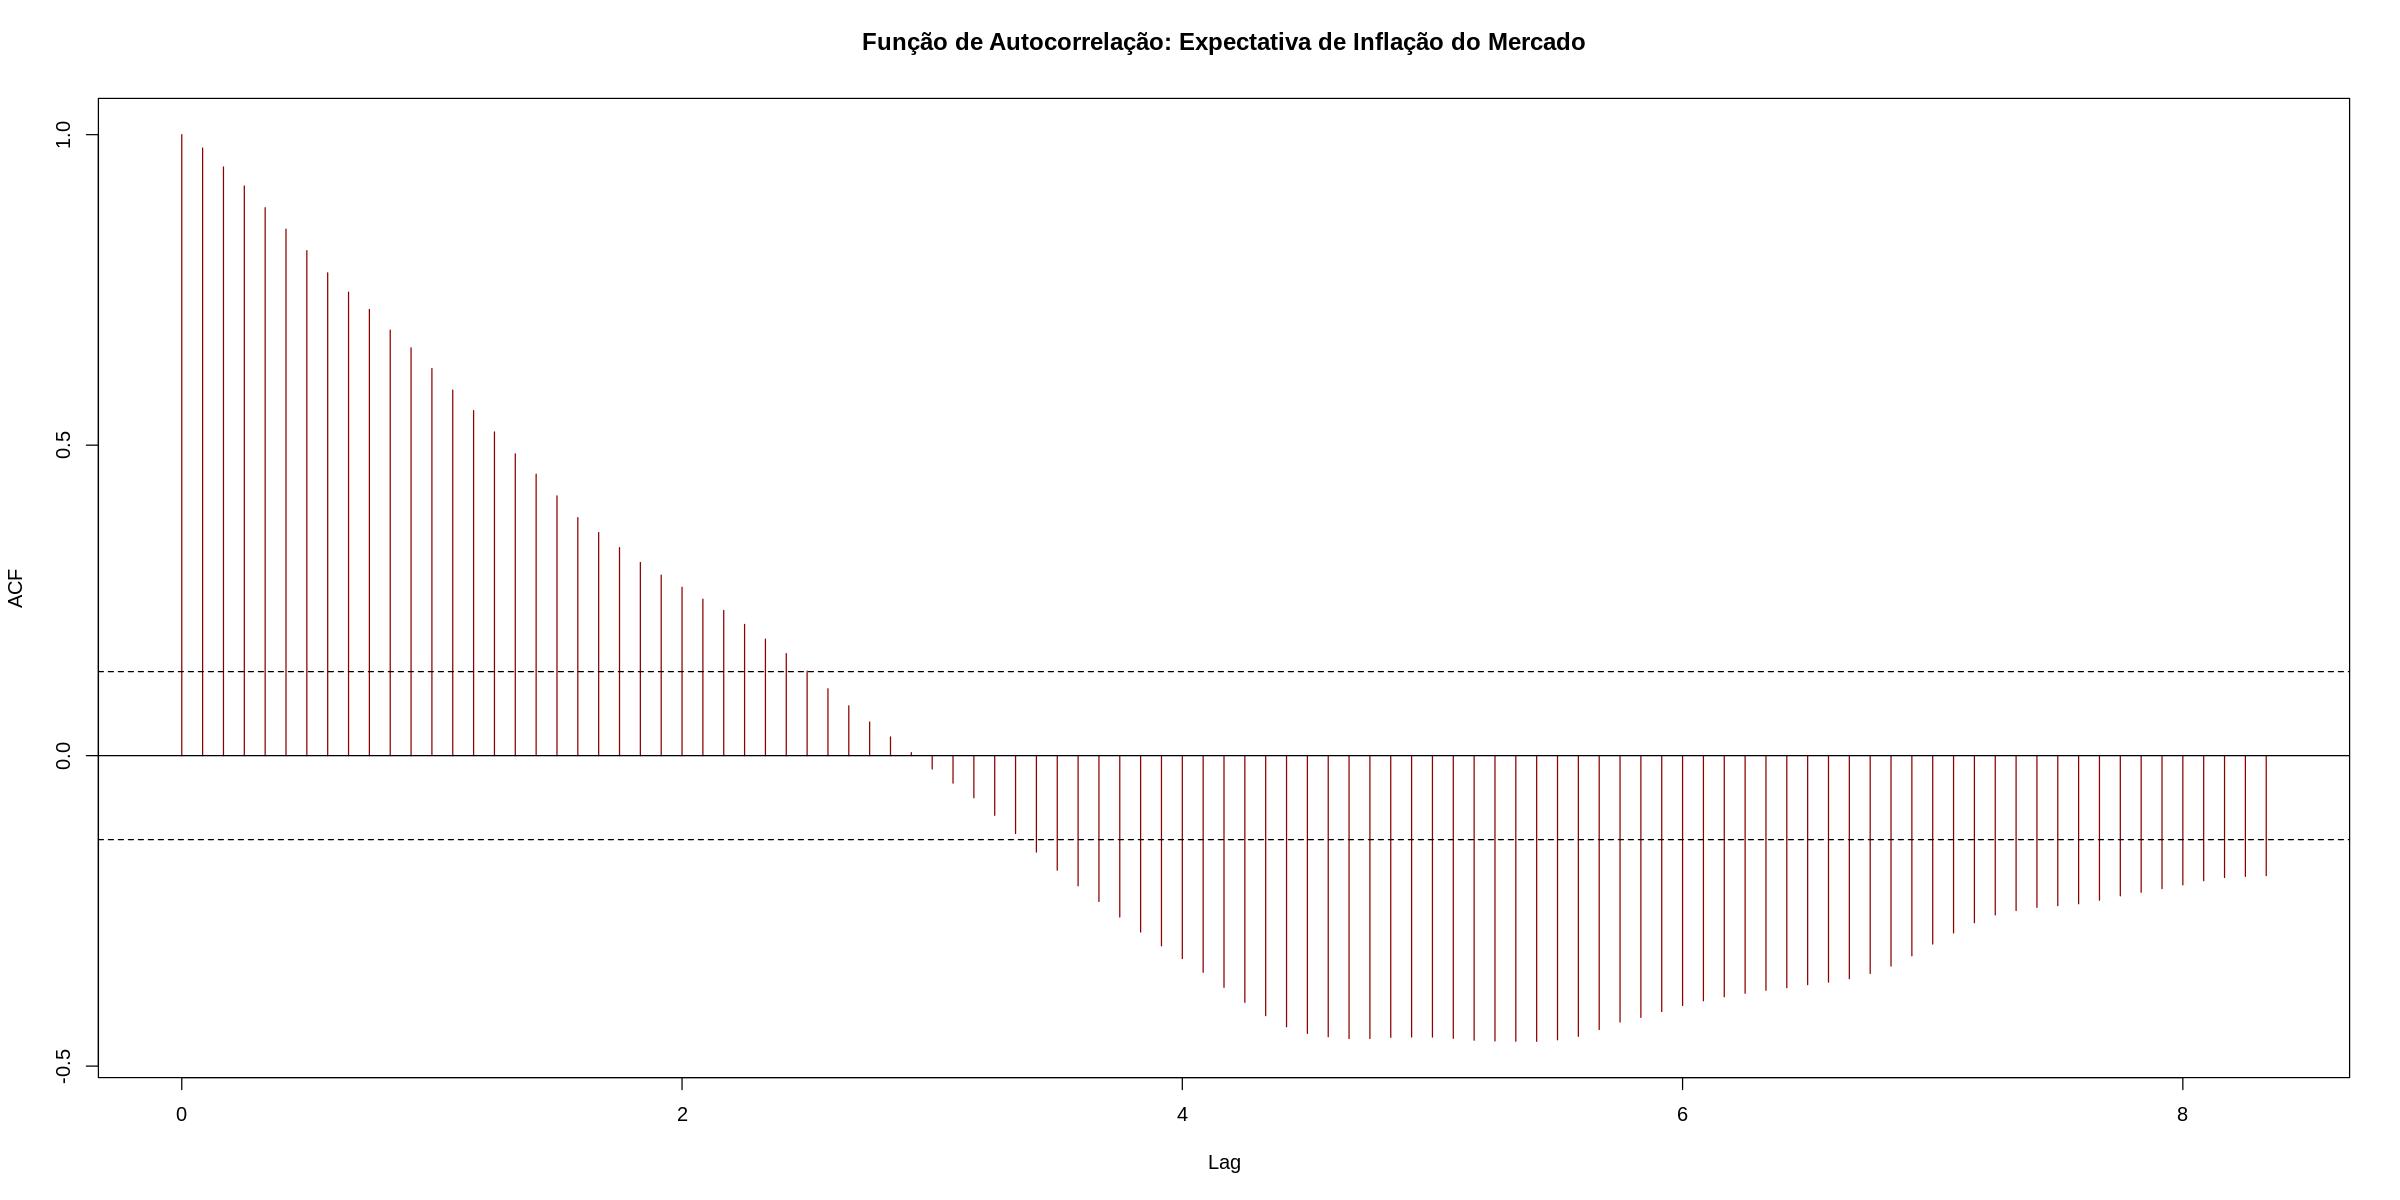

In [16]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 20, repr.plot.height = 10)

# Função de Autocorrelação
acf(df_public_data$market_inflation_expectation,
    main = "Função de Autocorrelação: Expectativa de Inflação do Mercado",
    col = "darkred",
    ci.col = "black",
    lag.max = 100)

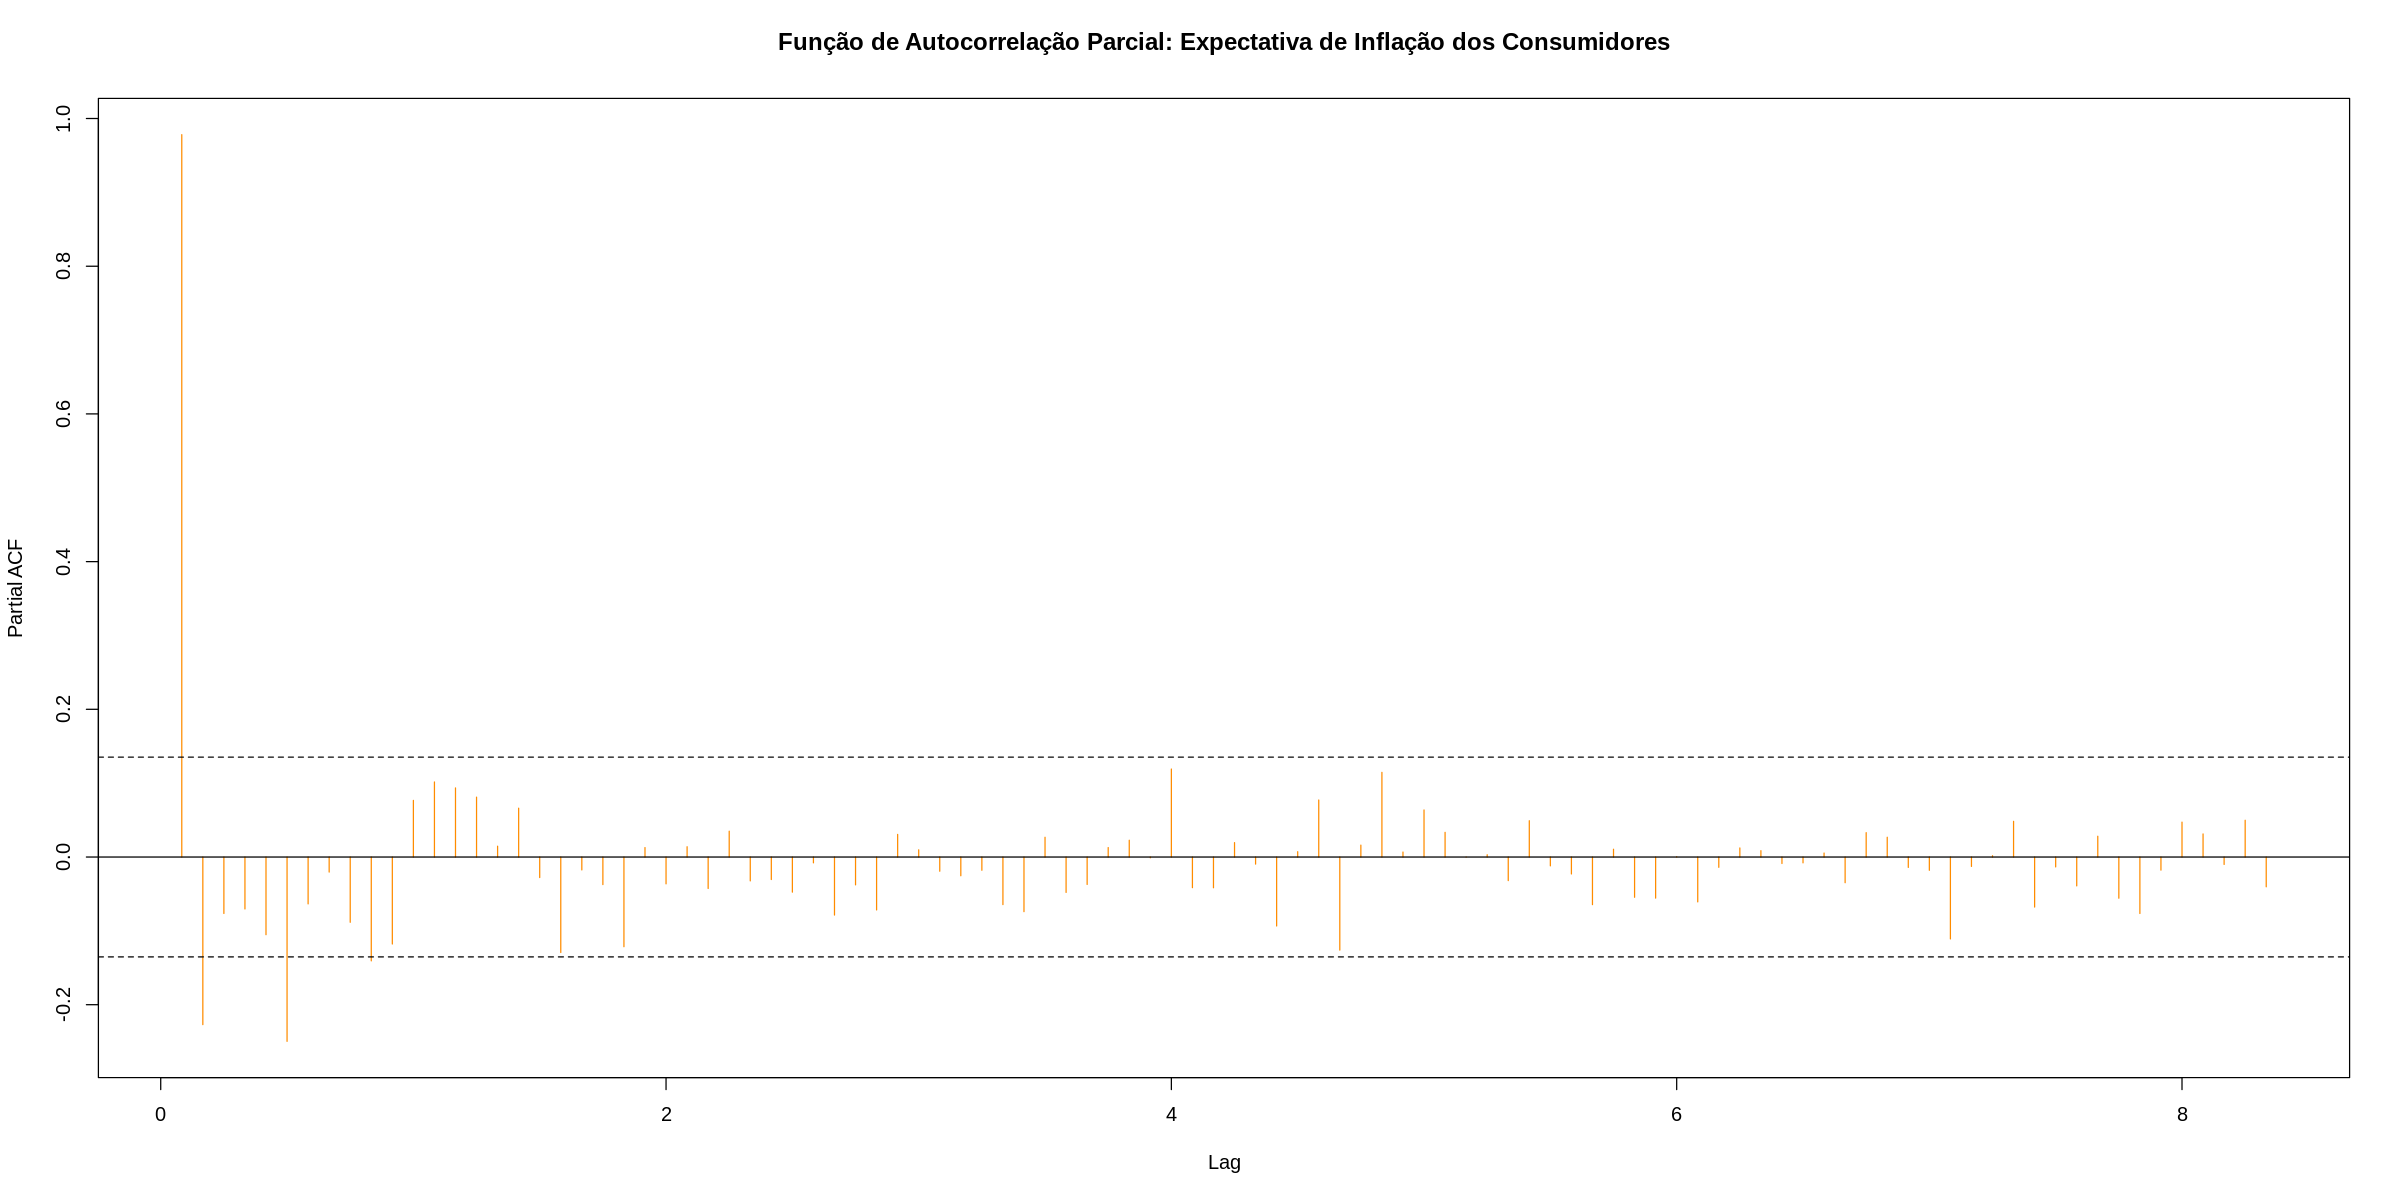

In [17]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 20, repr.plot.height = 10)

# Função de Autocorrelação Parcial
pacf(df_public_data$consumer_inflation_expectation,
    main = "Função de Autocorrelação Parcial: Expectativa de Inflação dos Consumidores",
    col = "darkorange",
    ci.col = "black",
    lag.max = 100)

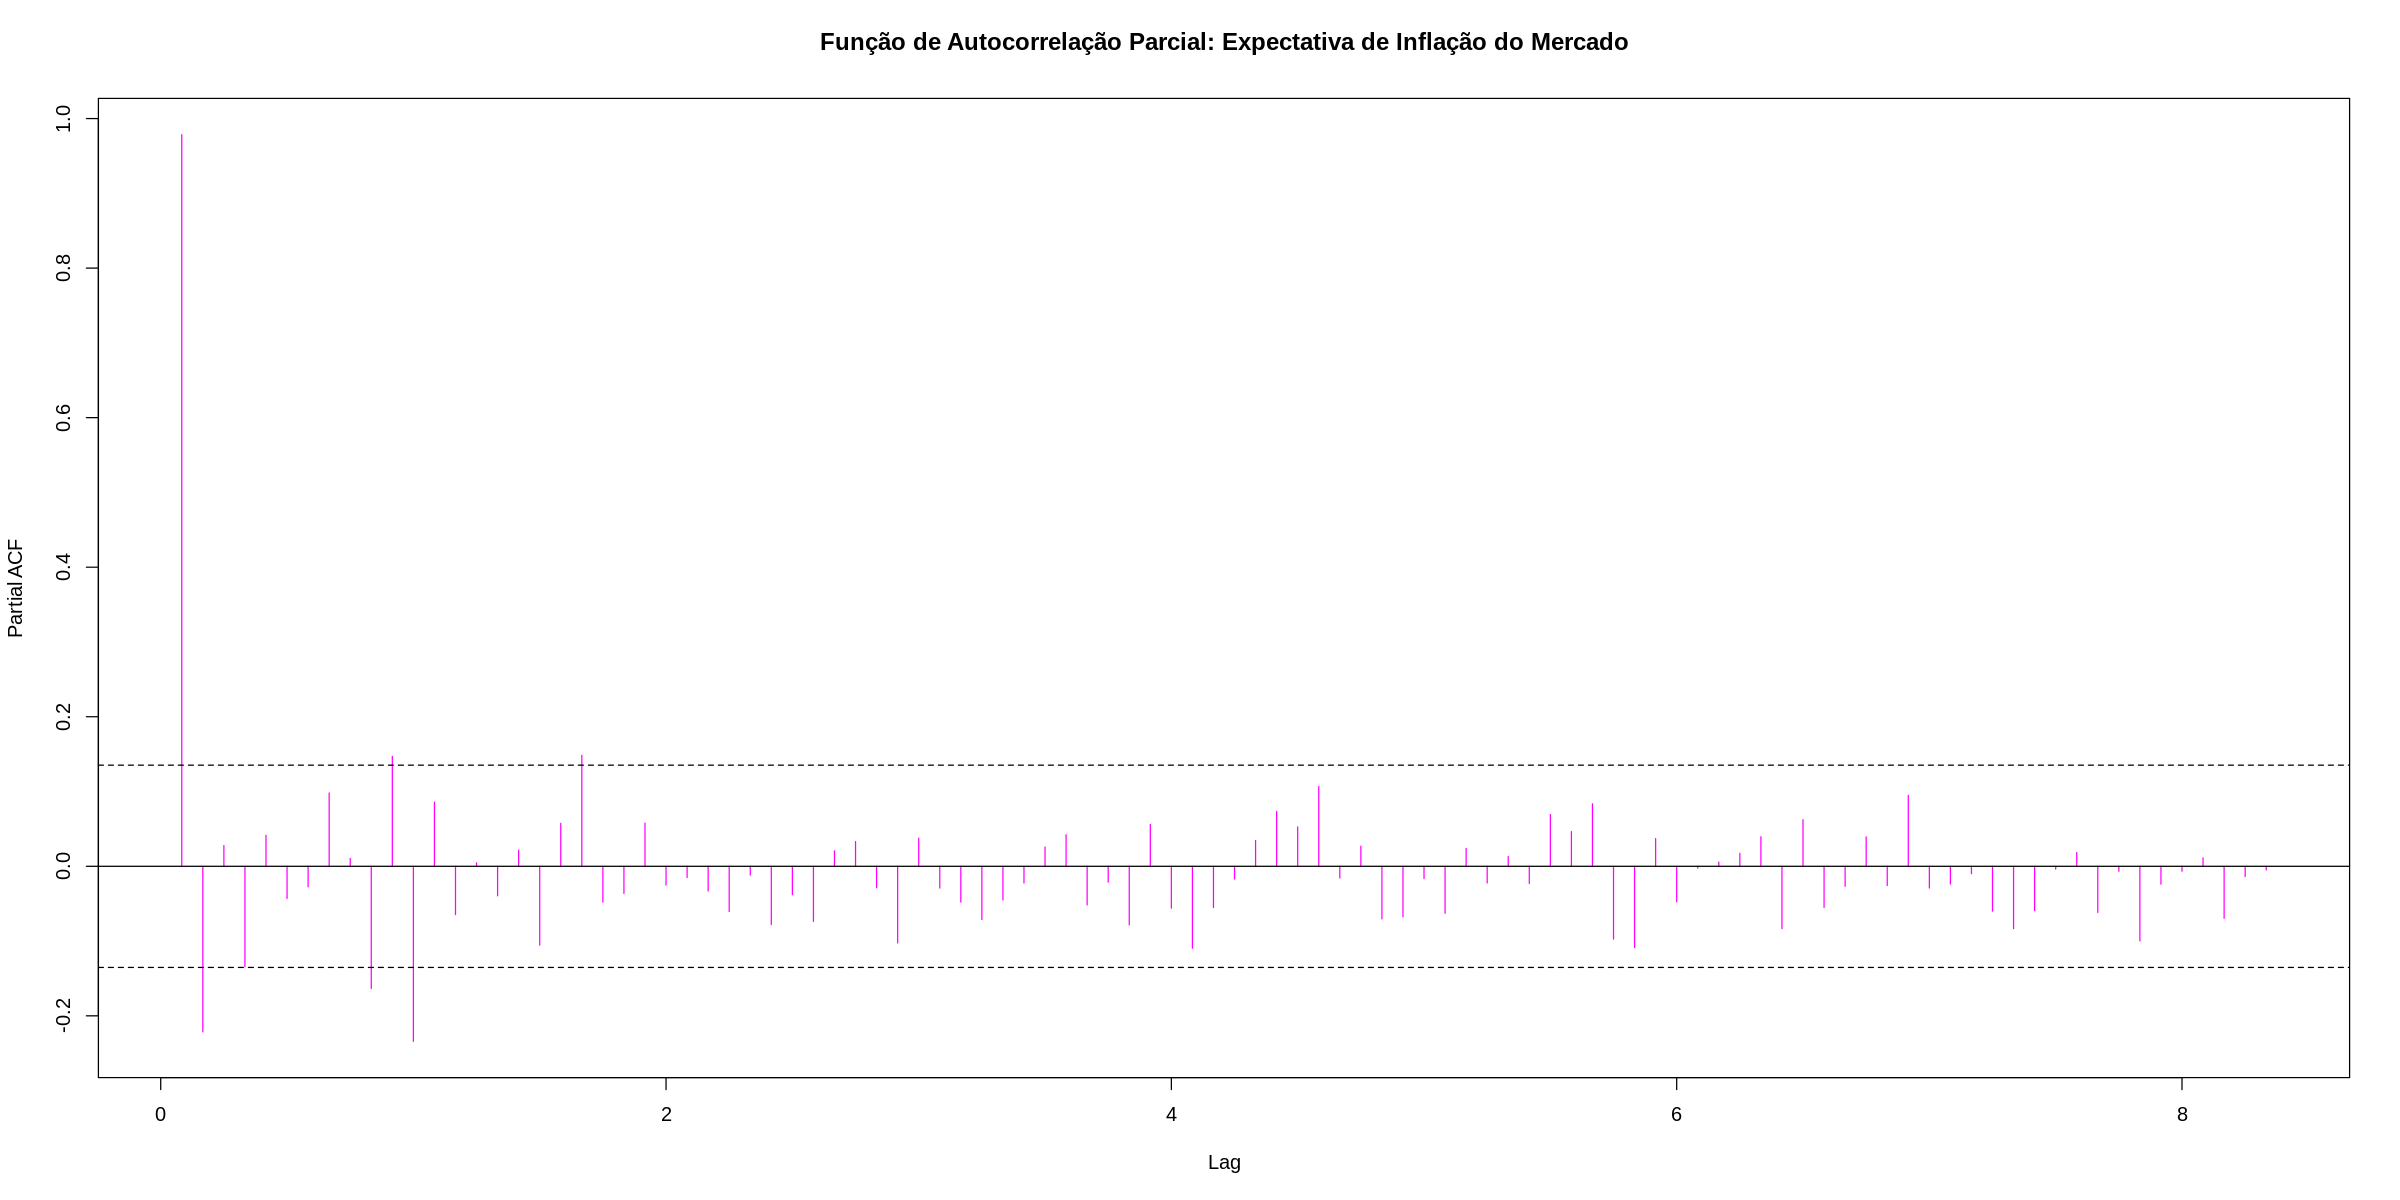

In [18]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 20, repr.plot.height = 10)

# Função de Autocorrelação Parcial
pacf(df_public_data$market_inflation_expectation,
    main = "Função de Autocorrelação Parcial: Expectativa de Inflação do Mercado",
    col = "magenta",
    ci.col = "black",
    lag.max = 100)

#### ADF (Augmented-Dickey-Fuller)

- $H_0$: possui raiz unitária

  * _tau3_: hipótese nula (raiz unitária)
  * _phi2_: hipótese nula (raiz unitária, sem tendência e sem drift)
  * _phi3_: hipótese nula (raiz unitária e sem tendência)

In [19]:
### Consumer Inflation Expectation
summary( ur.df( df_public_data$consumer_inflation_expectation, lags=12, type='trend') )


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.09677 -0.18560 -0.00357  0.16660  0.94785 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)   
(Intercept)   0.3515298  0.1292630   2.719  0.00717 **
z.lag.1      -0.0534263  0.0184523  -2.895  0.00425 **
tt            0.0002051  0.0004114   0.499  0.61869   
z.diff.lag1   0.1955855  0.0717856   2.725  0.00707 **
z.diff.lag2   0.0156361  0.0723755   0.216  0.82920   
z.diff.lag3   0.1000963  0.0732853   1.366  0.17367   
z.diff.lag4  -0.0227473  0.0732961  -0.310  0.75665   
z.diff.lag5   0.2425796  0.0732023   3.314  0.00111 **
z.diff.lag6   0.0650533  0.0745469   0.873  0.38400   
z.diff.lag7   0.0350018  0.0735912   0.476  0.63491   
z.diff.lag8   0.0362034  0.0732818   0.494 

**Resultado**

- Como, em módulo, os valores de test-statistic são **menores** que tau3, phi2 e phi3, **não se rejeita** as hipóteses nulas para um nível de significância de 10%, ou seja, a série temporal **possui raiz unitária**, o que significa que é **não-estacionária**.

In [20]:
### Market Inflation Expectation
summary( ur.df( df_public_data$market_inflation_expectation, lags=12, type='trend') )


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.68051 -0.09494  0.00893  0.10353  0.48780 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.1837407  0.0787683   2.333 0.020759 *  
z.lag.1      -0.0327461  0.0146501  -2.235 0.026619 *  
tt           -0.0002223  0.0002215  -1.004 0.316769    
z.diff.lag1   0.3703207  0.0731423   5.063 1.01e-06 ***
z.diff.lag2  -0.1145100  0.0775160  -1.477 0.141338    
z.diff.lag3   0.1836545  0.0754112   2.435 0.015841 *  
z.diff.lag4   0.0066769  0.0751151   0.089 0.929268    
z.diff.lag5   0.0026789  0.0743106   0.036 0.971281    
z.diff.lag6   0.0230546  0.0739968   0.312 0.755730    
z.diff.lag7  -0.0878857  0.0739289  -1.189 0.236072    
z.diff.lag8  -0.0963651  0.07425

**Resultado**

- Como, em módulo, os valores de test-statistic são **menores** que tau3, phi2 e phi3, **não se rejeita** as hipóteses nulas para um nível de significância de 10%, ou seja, a série temporal **possui raiz unitária**, o que significa que é **não-estacionária**.

#### KPSS

- $H_0$: não possui raiz unitária

In [21]:
### Consumer Inflation Expectation
summary( ur.kpss( df_public_data$consumer_inflation_expectation, type = "tau",     # média diferente de zero
                              lags = "short"    # poucos lags
                              ) )


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: tau with 4 lags. 

Value of test-statistic is: 0.2148 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.119 0.146  0.176 0.216


**Resultado**

- Como, em módulo, o valor de test-statistic é maior que o valor crítico, rejeita-se a hipótese nula para um nível de significância de 10%, ou seja, a série possui raiz unitária, o que significa que é não-estacionária.

In [22]:
### Market Inflation Expectation
summary( ur.kpss( df_public_data$market_inflation_expectation, type = "tau",     # média diferente de zero
                              lags = "short"    # poucos lags
                              ) )


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: tau with 4 lags. 

Value of test-statistic is: 0.5528 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.119 0.146  0.176 0.216


**Resultado**

- Como, em módulo, o valor de test-statistic é **maior** que o valor crítico, **rejeita-se** a hipótese nula para um nível de significância de 10%, ou seja, a série **possui raiz unitária**, o que significa que é **não-estacionária**.

### **Induzir Estacionariedade**

In [23]:
diff_consumer_inflation_expectation = diff( df_public_data$consumer_inflation_expectation )
diff_market_inflation_expectation = diff( df_public_data$market_inflation_expectation )
diff_ipca = diff( df_public_data$ipca )
diff_ipca_lag = diff( df_public_data$ipca_lag )
diff_selic = diff( df_public_data$selic )
diff_selic_lag = diff( df_public_data$selic_lag )

df_public_data_diff <- data.frame( month = time( diff_consumer_inflation_expectation ), diff_consumer_inflation_expectation, diff_market_inflation_expectation, diff_ipca, diff_ipca_lag, diff_selic, diff_selic_lag)

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Warning message:
“Removed 1 row containing missing values (`geom_line()`).”
Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


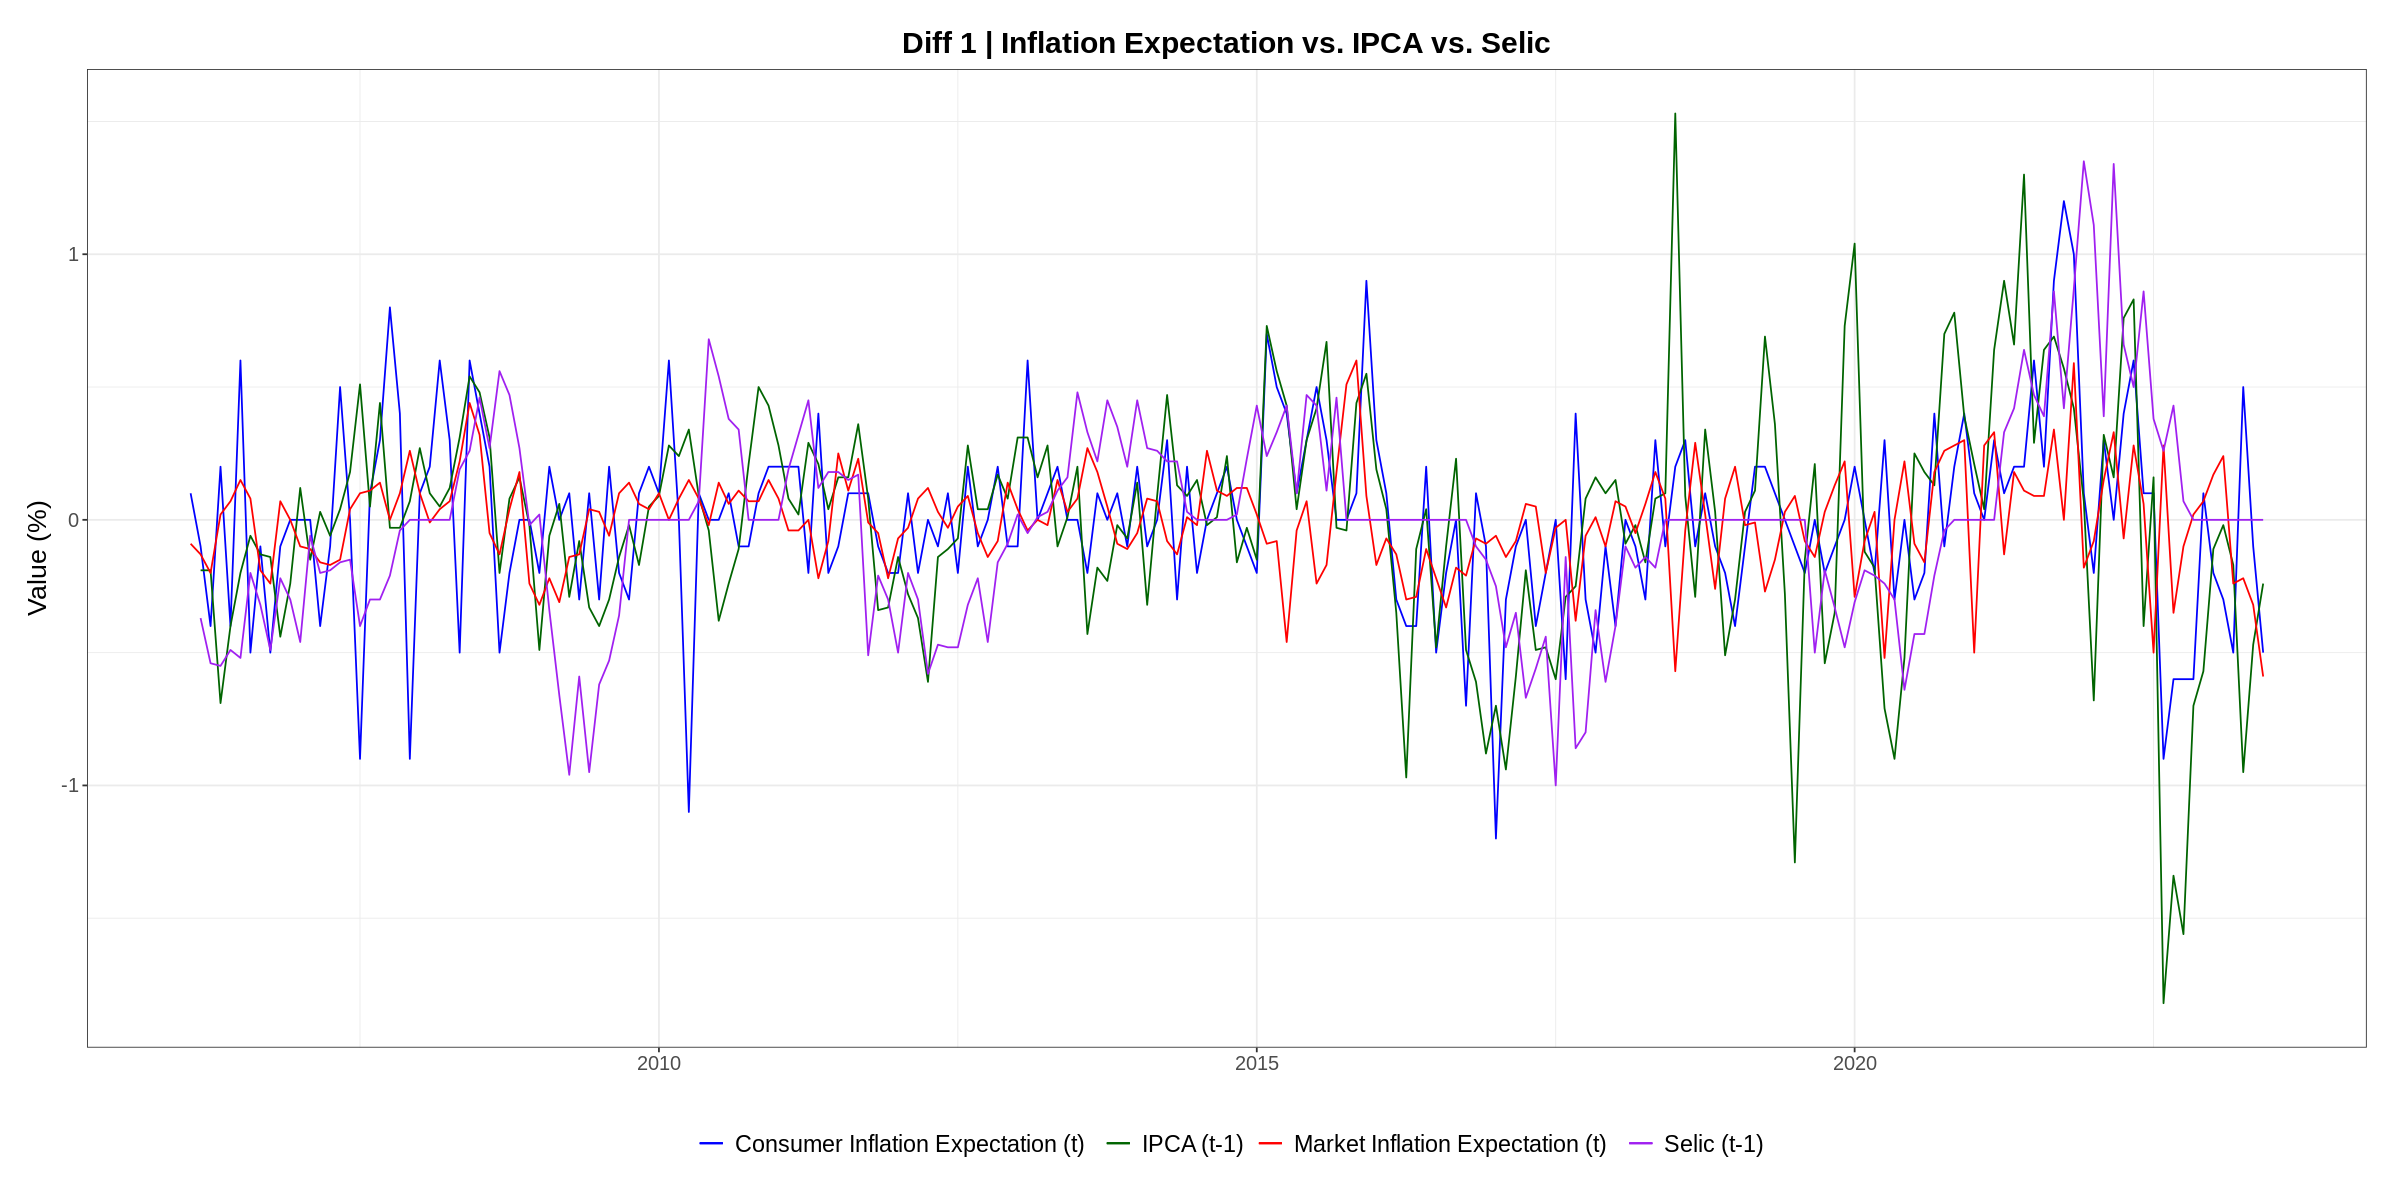

In [24]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 20, repr.plot.height = 10)

# Plotar as séries temporais de "consumer_inflation_expectation" e "market_inflation_expectation"
ggplot(df_public_data_diff) +
  geom_line(aes(x = month, y = diff_consumer_inflation_expectation, color = "Consumer Inflation Expectation (t)")) +
  geom_line(aes(x = month, y = diff_ipca_lag, color = "IPCA (t-1)")) +
  geom_line(aes(x = month, y = diff_market_inflation_expectation, color = "Market Inflation Expectation (t)")) +
  geom_line(aes(x = month, y = diff_selic_lag, color = "Selic (t-1)")) +
  labs(x = "", y = "Value (%)", title = "Diff 1 | Inflation Expectation vs. IPCA vs. Selic") +
  scale_color_manual(values = c("blue", "darkgreen", "red", "purple"), name = "") +
  theme_bw() +
  theme(
    legend.position = "bottom",
    legend.text = element_text(size = 14),
    legend.title = element_blank(),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    axis.text = element_text(size = 12),
    axis.title.y = element_text(size = 16, vjust = 2),
    axis.title.x = element_text(size = 14),
    plot.caption = element_text(size = 10),
    plot.margin = margin(20, 20, 20, 20)
  )

#### ADF (Augmented-Dickey-Fuller)

- $H_0$: possui raiz unitária

  * _tau3_: hipótese nula (raiz unitária)
  * _phi2_: hipótese nula (raiz unitária, sem tendência e sem drift)
  * _phi3_: hipótese nula (raiz unitária e sem tendência)

In [25]:
### Consumer Inflation Expectation
summary( ur.df( df_public_data_diff$diff_consumer_inflation_expectation, lags=12, type='trend') )


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.12882 -0.15898  0.00344  0.17210  0.95045 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.321e-04  5.110e-02   0.003 0.997941    
z.lag.1      -7.039e-01  1.643e-01  -4.284 2.98e-05 ***
tt            9.007e-05  4.166e-04   0.216 0.829056    
z.diff.lag1  -1.253e-01  1.601e-01  -0.782 0.434978    
z.diff.lag2  -1.341e-01  1.568e-01  -0.855 0.393512    
z.diff.lag3  -2.687e-02  1.578e-01  -0.170 0.865020    
z.diff.lag4  -5.173e-02  1.559e-01  -0.332 0.740488    
z.diff.lag5   1.794e-01  1.529e-01   1.173 0.242199    
z.diff.lag6   2.190e-01  1.492e-01   1.468 0.143822    
z.diff.lag7   2.357e-01  1.468e-01   1.606 0.110113    
z.diff.lag8   2.592e-01  1.412e-

**Resultado**

- Como, em módulo, os valores de test-statistic são **maiores** que tau3, phi2 e phi3, **rejeita-se** as hipóteses nulas para um nível de significância de 10%, ou seja, a série temporal **não possui raiz unitária**, o que significa que é **estacionária**.

In [26]:
### Market Inflation Expectation
summary( ur.df( df_public_data_diff$diff_market_inflation_expectation, lags=12, type='trend') )


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.67248 -0.10017  0.00189  0.10440  0.45024 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)   
(Intercept)   0.0210877  0.0279321   0.755  0.45125   
z.lag.1      -0.6595802  0.1984075  -3.324  0.00107 **
tt           -0.0001825  0.0002250  -0.811  0.41841   
z.diff.lag1   0.0246003  0.1937529   0.127  0.89911   
z.diff.lag2  -0.1110179  0.1878525  -0.591  0.55527   
z.diff.lag3   0.0619693  0.1756362   0.353  0.72463   
z.diff.lag4   0.0414614  0.1688426   0.246  0.80630   
z.diff.lag5   0.0215485  0.1551823   0.139  0.88972   
z.diff.lag6   0.0293766  0.1455911   0.202  0.84032   
z.diff.lag7  -0.0707812  0.1379464  -0.513  0.60850   
z.diff.lag8  -0.1790128  0.1297954  -1.379 

**Resultado**

- Como, em módulo, os valores de test-statistic são **maiores** que tau3 e phi3, mas não que phi2, **rejeita-se** 2 das 3 hipóteses nulas para um nível de significância de 10%, ou seja, a série temporal **não possui raiz unitária**, o que significa que é **estacionária**, mas a série é **não estacionária** após a segunda diferenciação.

#### KPSS

- $H_0$: não possui raiz unitária

In [27]:
### Consumer Inflation Expectation
summary( ur.kpss( df_public_data_diff$diff_consumer_inflation_expectation, type = "tau",     # média diferente de zero
                              lags = "short"    # poucos lags
                              ) )


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: tau with 4 lags. 

Value of test-statistic is: 0.0698 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.119 0.146  0.176 0.216


**Resultado**

- Como, em módulo, o valor de test-statistic é **menor** que o valor crítico, **não se rejeita** a hipótese nula para um nível de significância de 10%, ou seja, a série **não possui raiz unitária**, o que significa que é **estacionária**.

In [28]:
### Market Inflation Expectation
summary( ur.kpss( df_public_data_diff$diff_market_inflation_expectation, type = "tau",     # média diferente de zero
                              lags = "short"    # poucos lags
                              ) )


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: tau with 4 lags. 

Value of test-statistic is: 0.0661 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.119 0.146  0.176 0.216


**Resultado**

- Como, em módulo, o valor de test-statistic é **menor** que o valor crítico, **não se rejeita** a hipótese nula para um nível de significância de 10%, ou seja, a série **não possui raiz unitária**, o que significa que é **estacionária**.

### **Modelo Linear**

In [29]:
# Consumer Inflation Expectation
ols_model_consumer <- lm(consumer_inflation_expectation ~ ipca_lag - 1, data = df_public_data)

summary(ols_model_consumer)


Call:
lm(formula = consumer_inflation_expectation ~ ipca_lag - 1, data = df_public_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3668 -0.2980  0.3924  1.3609  3.8906 

Coefficients:
         Estimate Std. Error t value Pr(>|t|)    
ipca_lag  1.14202    0.01576   72.46   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.398 on 208 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.9619,	Adjusted R-squared:  0.9617 
F-statistic:  5250 on 1 and 208 DF,  p-value: < 2.2e-16


Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


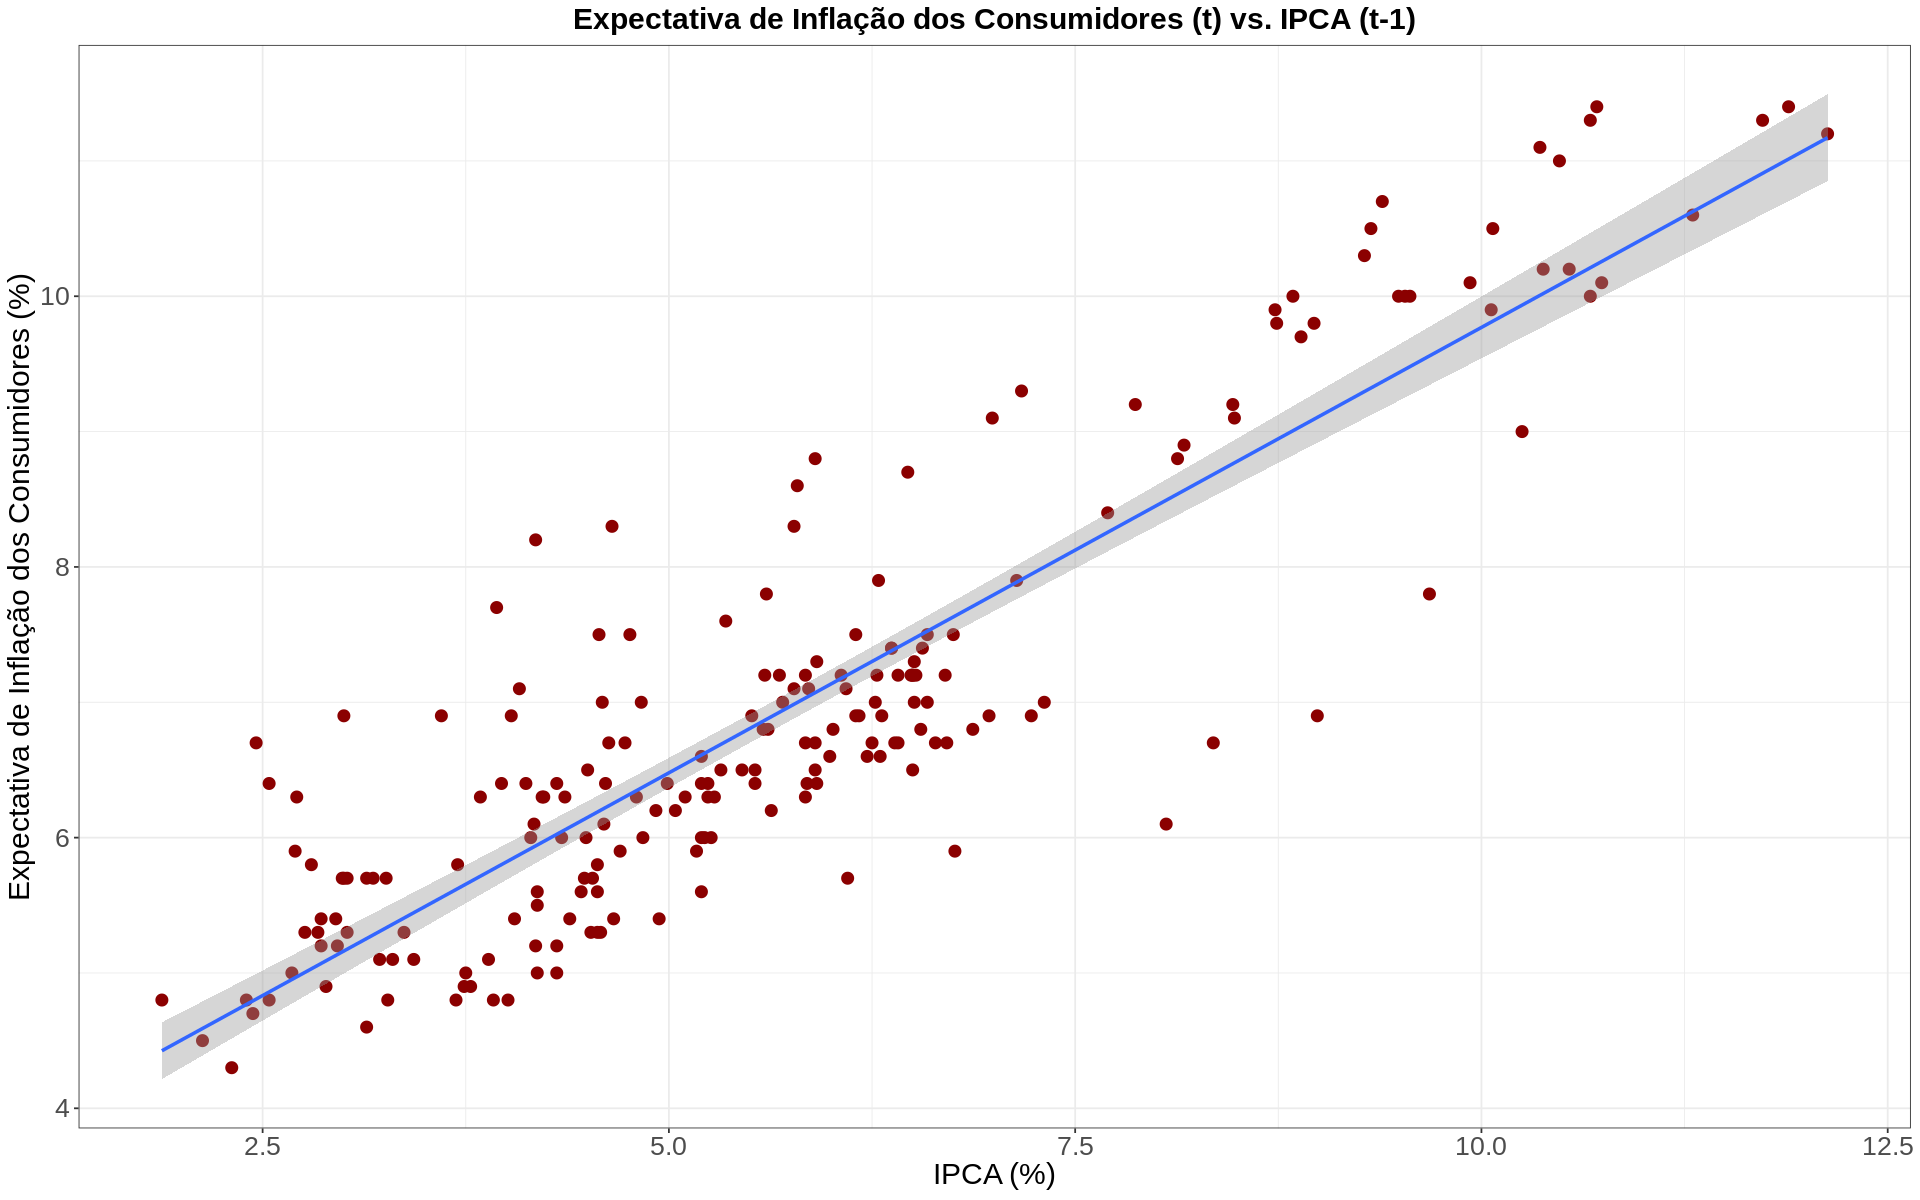

In [30]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 16, repr.plot.height = 10)

# Plotar o gráfico de dispersão de "consumer_inflation_expectation" e "ipca_lag" com regressão linear
ggplot(df_public_data, aes(x = ipca_lag, y = consumer_inflation_expectation)) +
  geom_point(color = "darkred", size = 3) +
  geom_smooth(method = "lm") +
  labs(x = "IPCA (%)", y = "Expectativa de Inflação dos Consumidores (%)", title = "Expectativa de Inflação dos Consumidores (t) vs. IPCA (t-1)") +
  theme_bw() +
  theme(legend.text = element_text(size = 12),
        legend.title = element_text("Ano"),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.caption = element_text(size = 14))

In [31]:
# Market Inflation Expectation
ols_model_market <- lm(market_inflation_expectation ~ ipca_lag - 1, data = df_public_data)

summary(ols_model_market)


Call:
lm(formula = market_inflation_expectation ~ ipca_lag - 1, data = df_public_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8634  0.0675  0.7241  1.2493  2.3400 

Coefficients:
         Estimate Std. Error t value Pr(>|t|)    
ipca_lag  0.77489    0.01498   51.72   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.329 on 208 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.9279,	Adjusted R-squared:  0.9275 
F-statistic:  2675 on 1 and 208 DF,  p-value: < 2.2e-16


Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


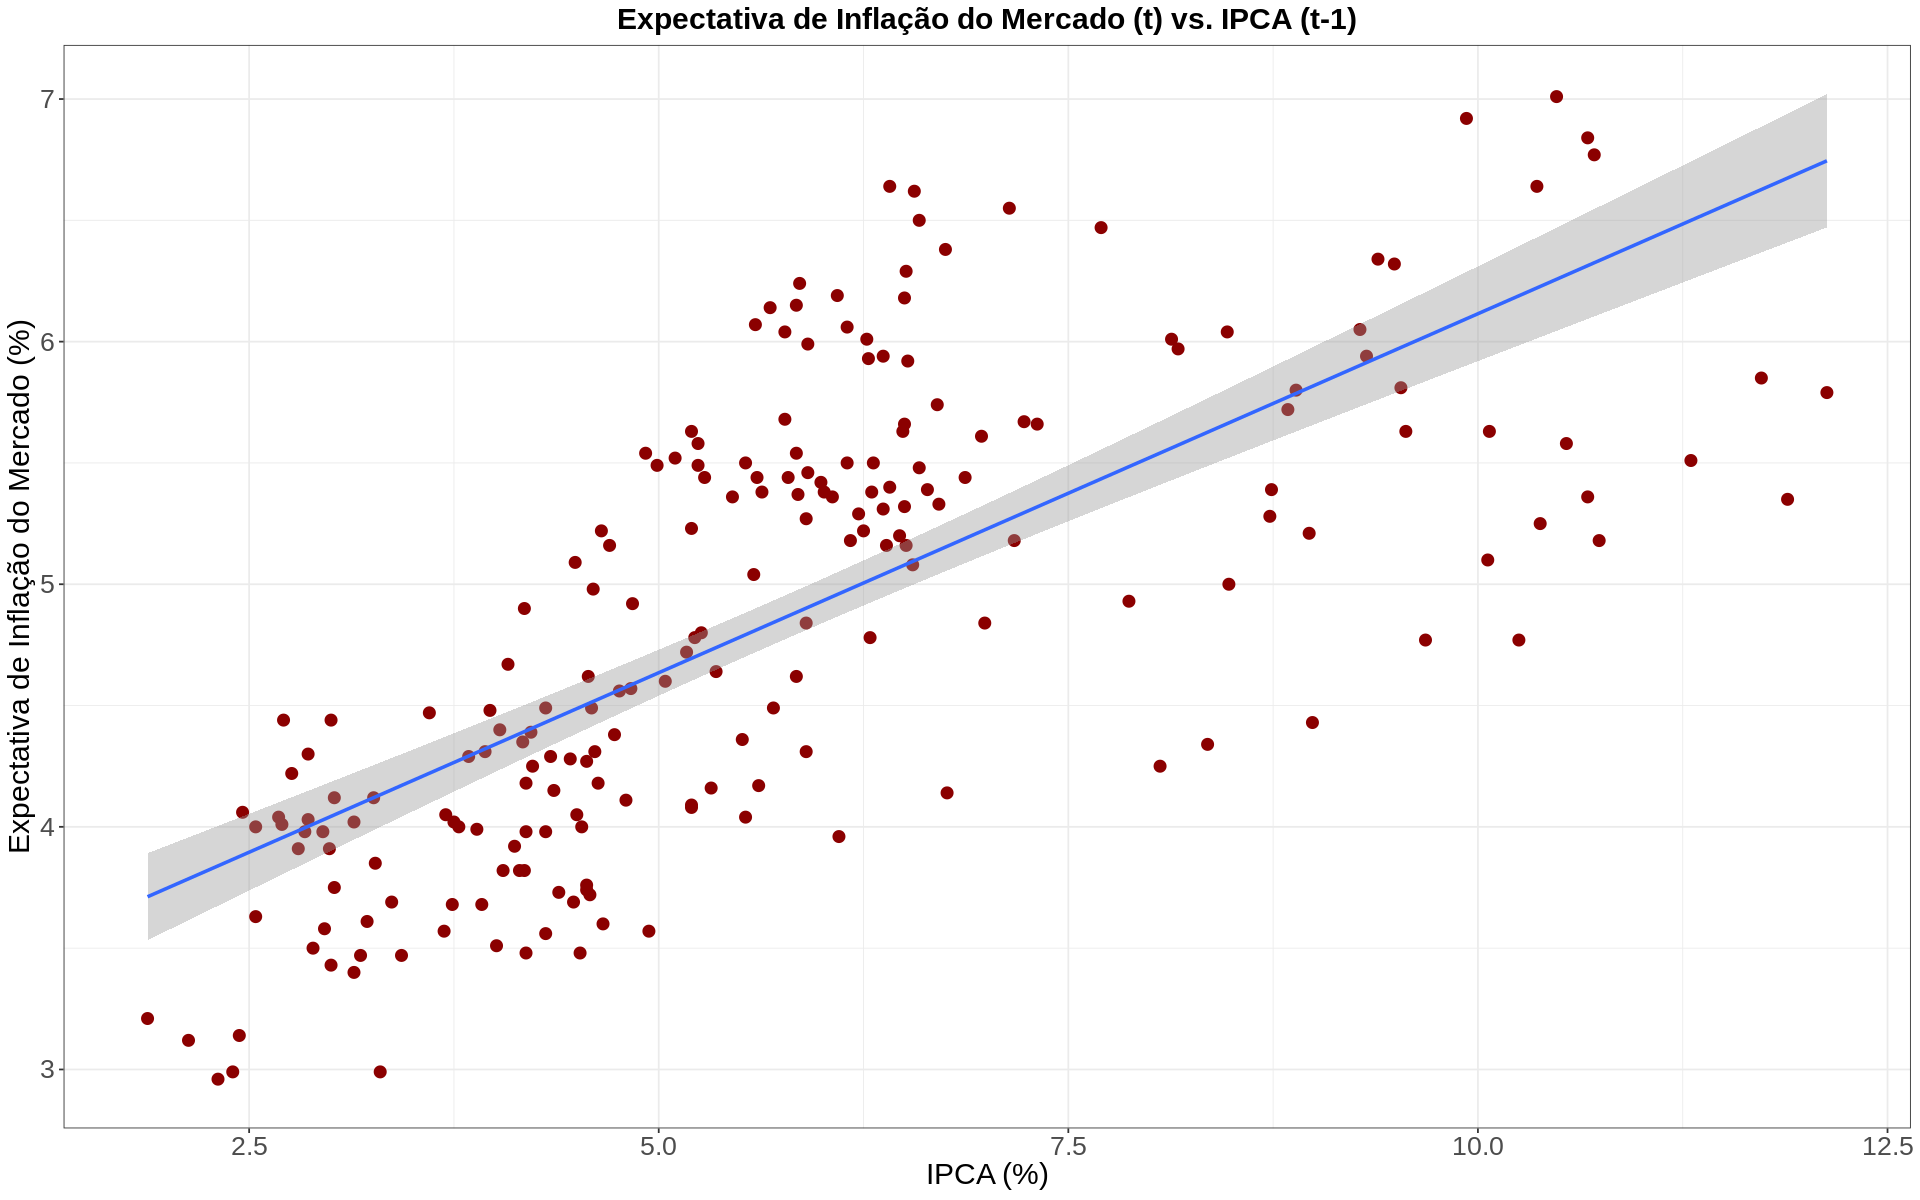

In [32]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 16, repr.plot.height = 10)

# Plotar o gráfico de dispersão de "market_inflation_expectation" e "ipca_lag" com regressão linear
ggplot(df_public_data, aes(x = ipca_lag, y = market_inflation_expectation)) +
  geom_point(color = "darkred", size = 3) +
  geom_smooth(method = "lm") +
  labs(x = "IPCA (%)", y = "Expectativa de Inflação do Mercado (%)", title = "Expectativa de Inflação do Mercado (t) vs. IPCA (t-1)") +
  theme_bw() +
  theme(legend.text = element_text(size = 12),
        legend.title = element_text("Ano"),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.caption = element_text(size = 14))

### **Modelo VAR**

In [33]:
# Remover a primeira linha do dataframe com valores nulos
df_public_data_filtered <- df_public_data[-1, ]

# Ajuste as colunas de séries temporais de volta para o formato time series
df_public_data_filtered$consumer_inflation_expectation <- ts(df_public_data_filtered$consumer_inflation_expectation, start = c(2006, 3), frequency = 12)
df_public_data_filtered$ipca_lag <- ts(df_public_data_filtered$ipca_lag, start = c(2006, 3), frequency = 12)

# Selecionar variáveis do modelo VAR
var_model_variables <- df_public_data_filtered[, c("consumer_inflation_expectation", "ipca_lag")]

In [34]:
# Selecionar a ordem adequada do modelo VAR
lag_select <- VARselect(var_model_variables, lag.max = 12, type = "const")

print(lag_select$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
     2      2      2      2 


In [35]:
# Ajustar o modelo VAR com uma ordem escolhida
var_model = VAR(var_model_variables, p = 2, type = "const")

summary(var_model)


VAR Estimation Results:
Endogenous variables: consumer_inflation_expectation, ipca_lag 
Deterministic variables: const 
Sample size: 207 
Log Likelihood: -113.058 
Roots of the characteristic polynomial:
0.9328 0.9328 0.5378 0.05023
Call:
VAR(y = var_model_variables, p = 2, type = "const")


Estimation results for equation consumer_inflation_expectation: 
consumer_inflation_expectation = consumer_inflation_expectation.l1 + ipca_lag.l1 + consumer_inflation_expectation.l2 + ipca_lag.l2 + const 

                                  Estimate Std. Error t value Pr(>|t|)    
consumer_inflation_expectation.l1  0.87058    0.07412  11.746  < 2e-16 ***
ipca_lag.l1                        0.30641    0.05368   5.708 4.03e-08 ***
consumer_inflation_expectation.l2 -0.01670    0.06958  -0.240 0.810593    
ipca_lag.l2                       -0.19623    0.05960  -3.292 0.001172 ** 
const                              0.38943    0.11237   3.466 0.000646 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.

In [36]:
# Serial Correlation
serial_test <- serial.test(var_model, lags.pt = 12, type = "PT.asymptotic")

print(serial_test)


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_model
Chi-squared = 75.937, df = 40, p-value = 0.000521



$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_model
Chi-squared = 75.937, df = 40, p-value = 0.000521



**Resultado**

- Como o p-value é menor que um nível de significância de 5%, não se pode afirmar que as variáveis não possuem correlação serial

In [37]:
# Heteroscedasticity
arch_test <- arch.test(var_model, lags.multi = 12, multivariate.only = TRUE)

print(arch_test)


	ARCH (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 129.68, df = 108, p-value = 0.07618



$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 129.68, df = 108, p-value = 0.07618



**Resultado**

- Como o p-value é **maior** que um nível de significância de 5%, pode-se afirmar que o modelo não possui heteroscedasticidade

In [38]:
# Normal Distribution of Residuals
normal_test <- normality.test(var_model, multivariate.only = TRUE)

print(normal_test)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 57.687, df = 4, p-value = 8.878e-12


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 0.91643, df = 2, p-value = 0.6324


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 56.77, df = 2, p-value = 4.704e-13




$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 57.687, df = 4, p-value = 8.878e-12


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 0.91643, df = 2, p-value = 0.6324


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 56.77, df = 2, p-value = 4.704e-13




**Resultado**

- Como o p-value é menor que um nível de significância de 5% no JB-test, não se pode afirmar que os resíduos são distribuídos de forma gaussiana

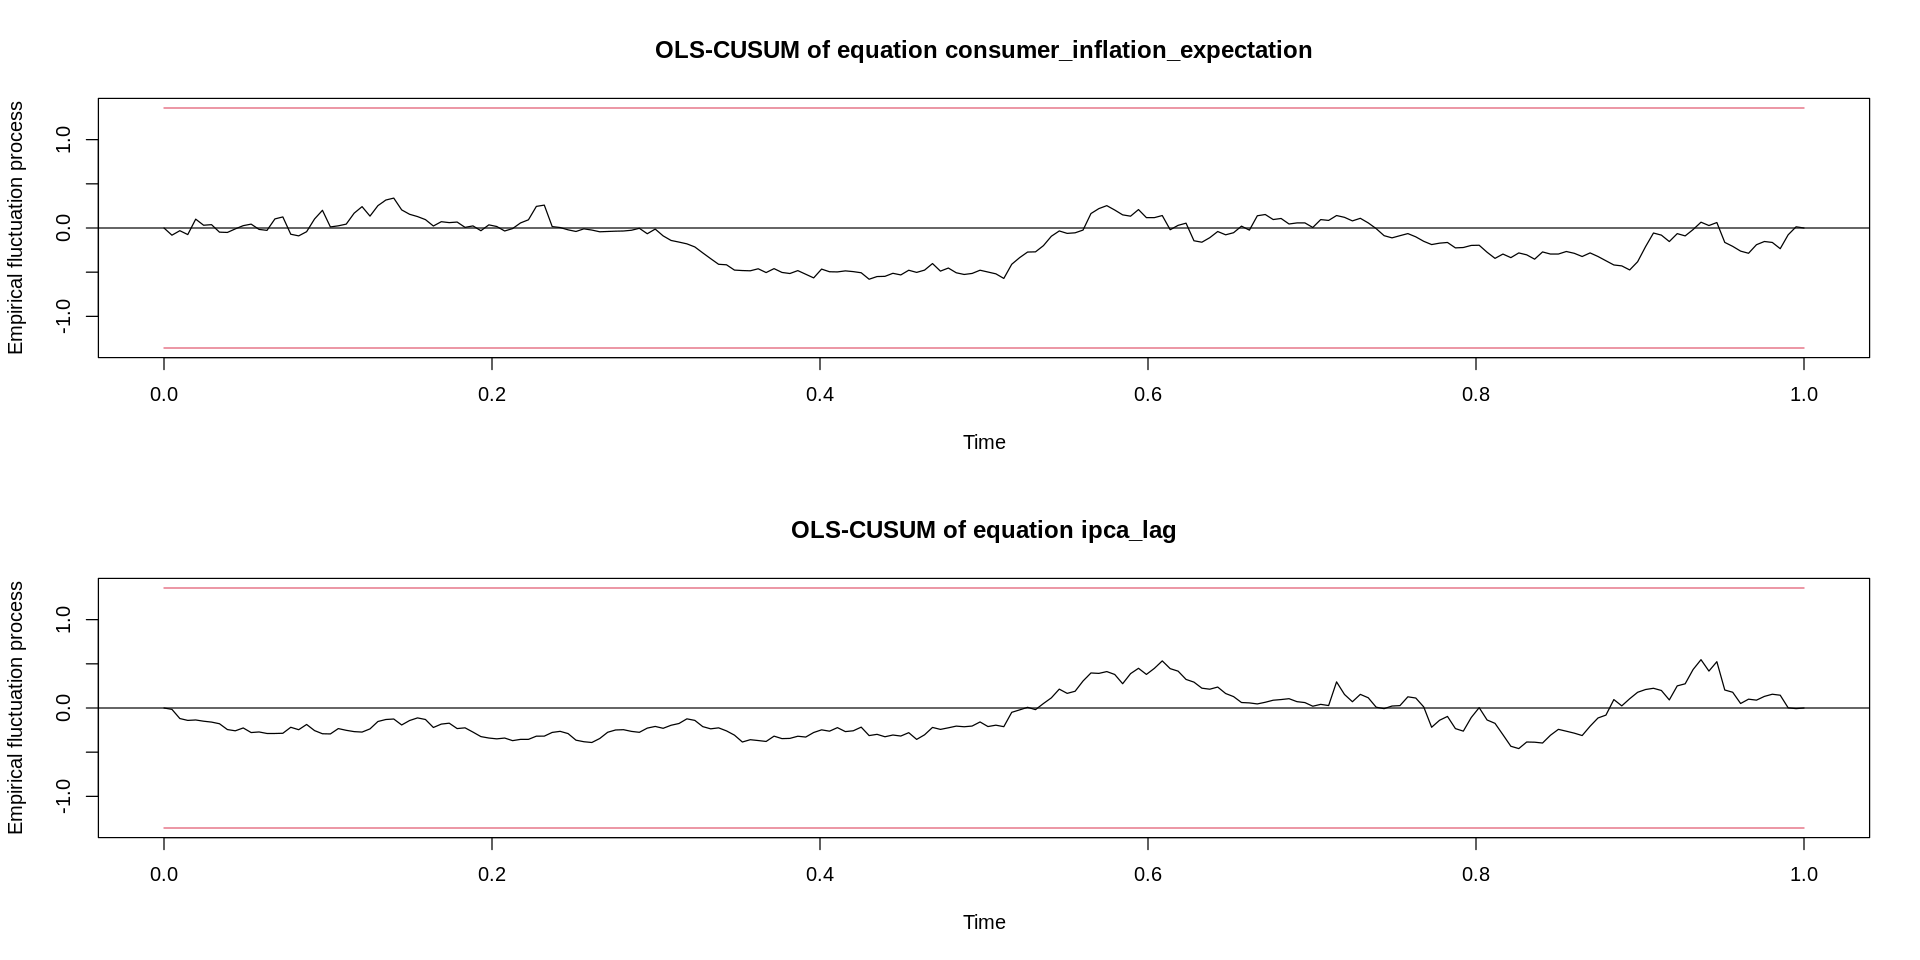

In [39]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 16, repr.plot.height = 8)

# Structural Breaks in Residuals
stability_test <- stability(var_model, type = "OLS-CUSUM")

plot(stability_test)

**Resultado**

- Como os valores estão entre as barras vermelhas, pode-se afirmar que não há quebra estrutural nos resíduos

In [40]:
# Granger Causality
granger_consumer_expectation <- causality(var_model, cause = "ipca_lag")

print(granger_consumer_expectation)

$Granger

	Granger causality H0: ipca_lag do not Granger-cause
	consumer_inflation_expectation

data:  VAR object var_model
F-Test = 29.146, df1 = 2, df2 = 404, p-value = 1.499e-12


$Instant

	H0: No instantaneous causality between: ipca_lag and
	consumer_inflation_expectation

data:  VAR object var_model
Chi-squared = 19.514, df = 1, p-value = 9.988e-06




**Resultado**

- Como o p-valor é menor que um nível de significância de 5%, pode-se rejeitar a hipótese nula do teste de Granger e afirmar que IPCA causa, no sentido de Granger, variação na expectativa de inflação do consumidor

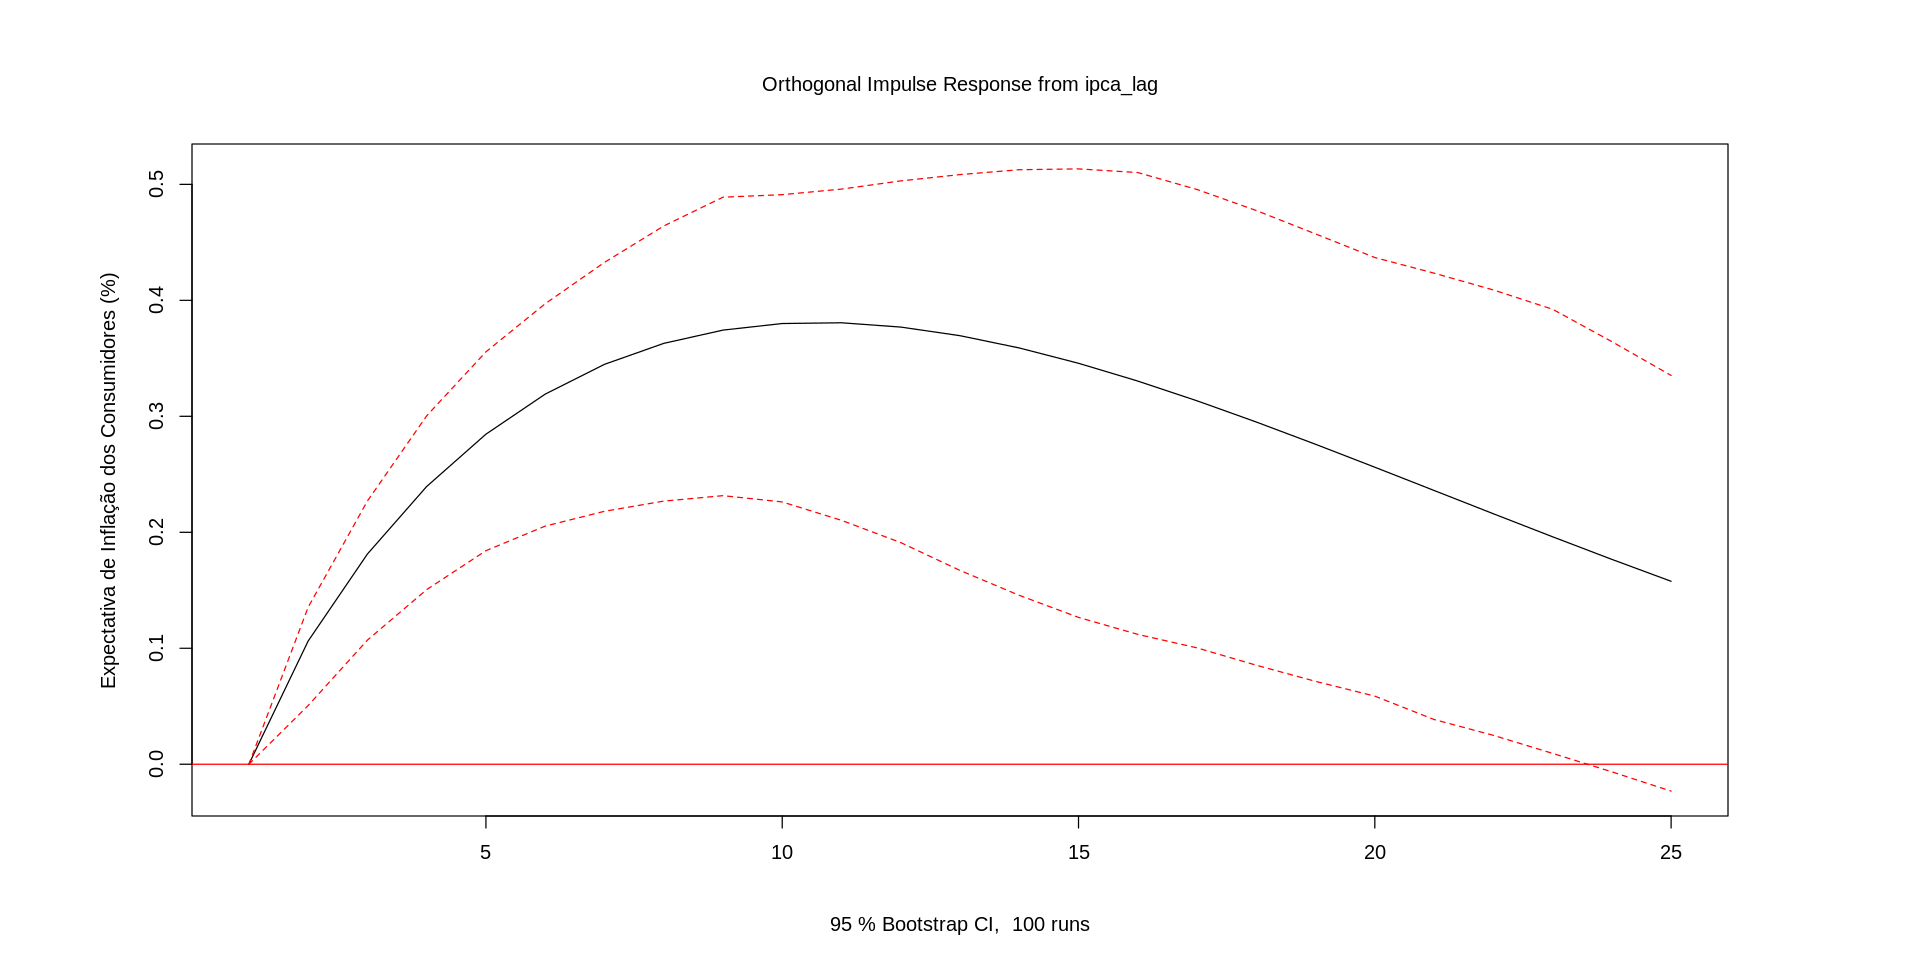

In [41]:
# Impulse Response Function
consumer_expectation_impulse = irf(var_model, impulse = "ipca_lag", response = "consumer_inflation_expectation", n.ahead = 24, boot = TRUE)

plot(consumer_expectation_impulse, ylab = "Expectativa de Inflação dos Consumidores (%)")

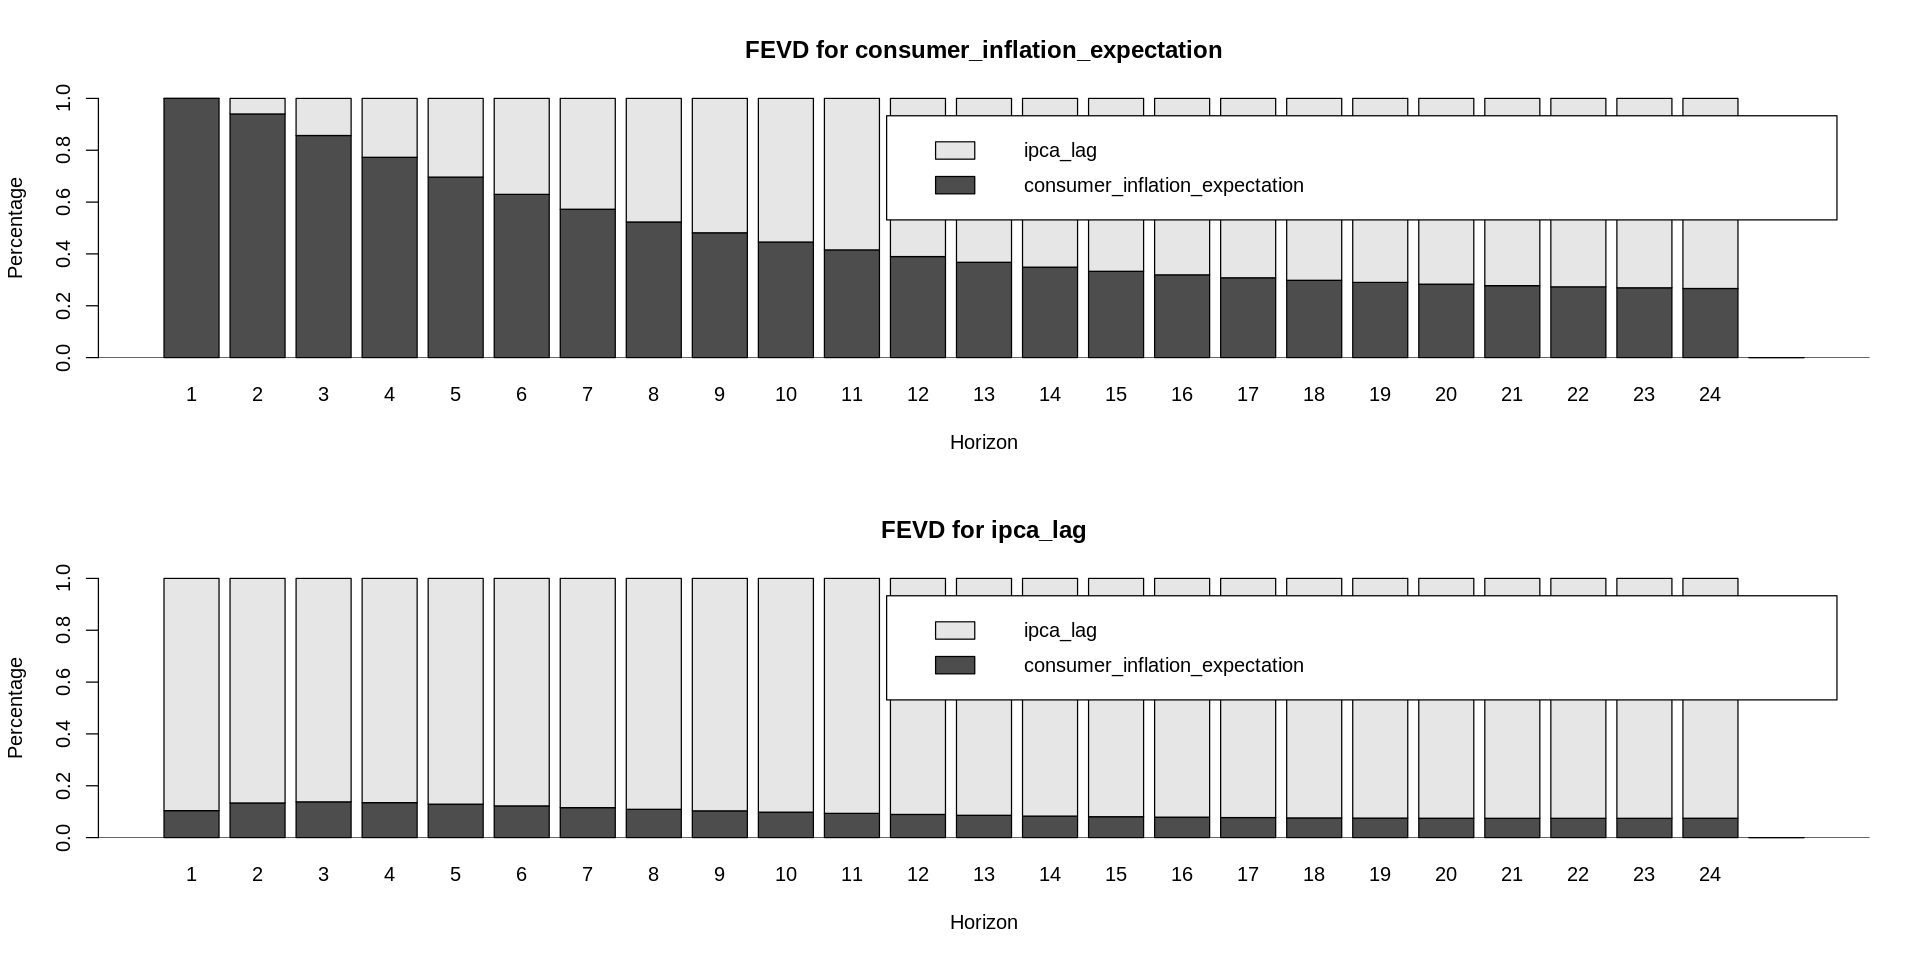

In [42]:
# Função de Variação de Valores Extremos
fevd_model <- fevd(var_model, n.ahead = 24)

plot(fevd_model)

**Resultado**

- Depois de ~8 meses, a Expectativa de Inflação dos Consumidores é mais explicada pelo IPCA do que a própria variável Expectativa de Inflação dos Consumidores

- A variável IPCA é, aproximadamente em sua totalidade, explicada pelo próprio IPCA

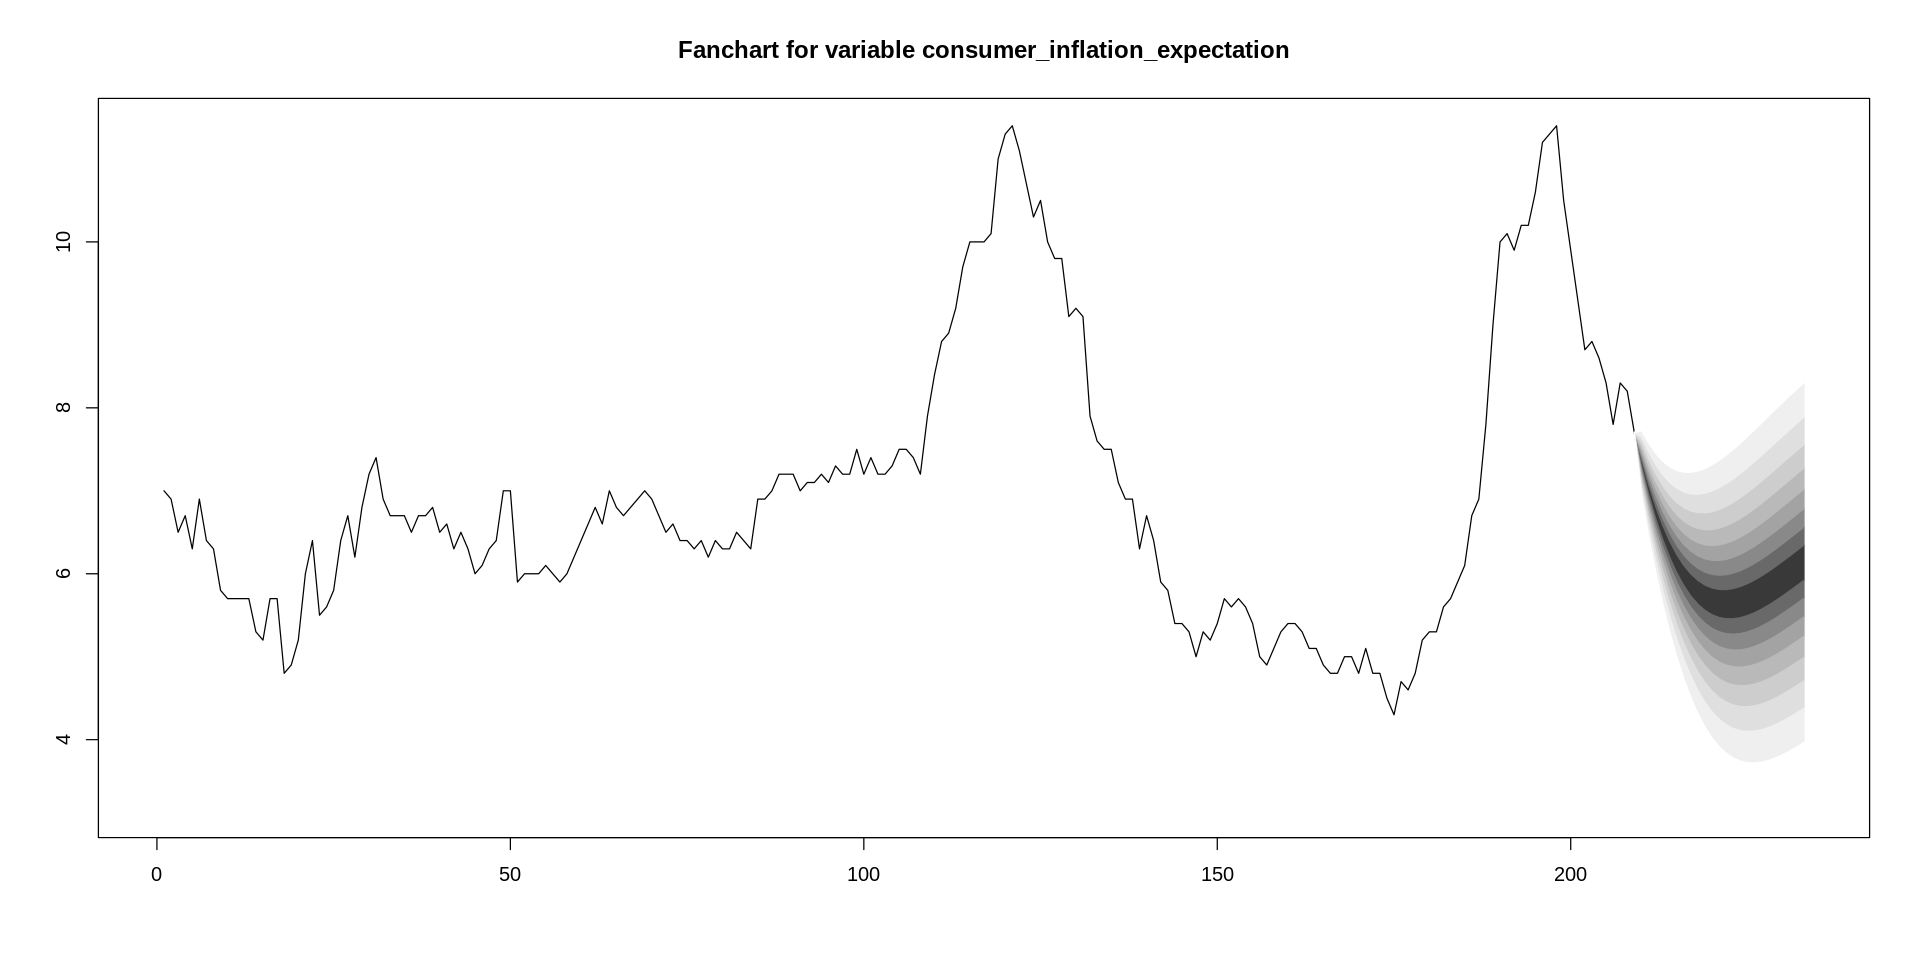

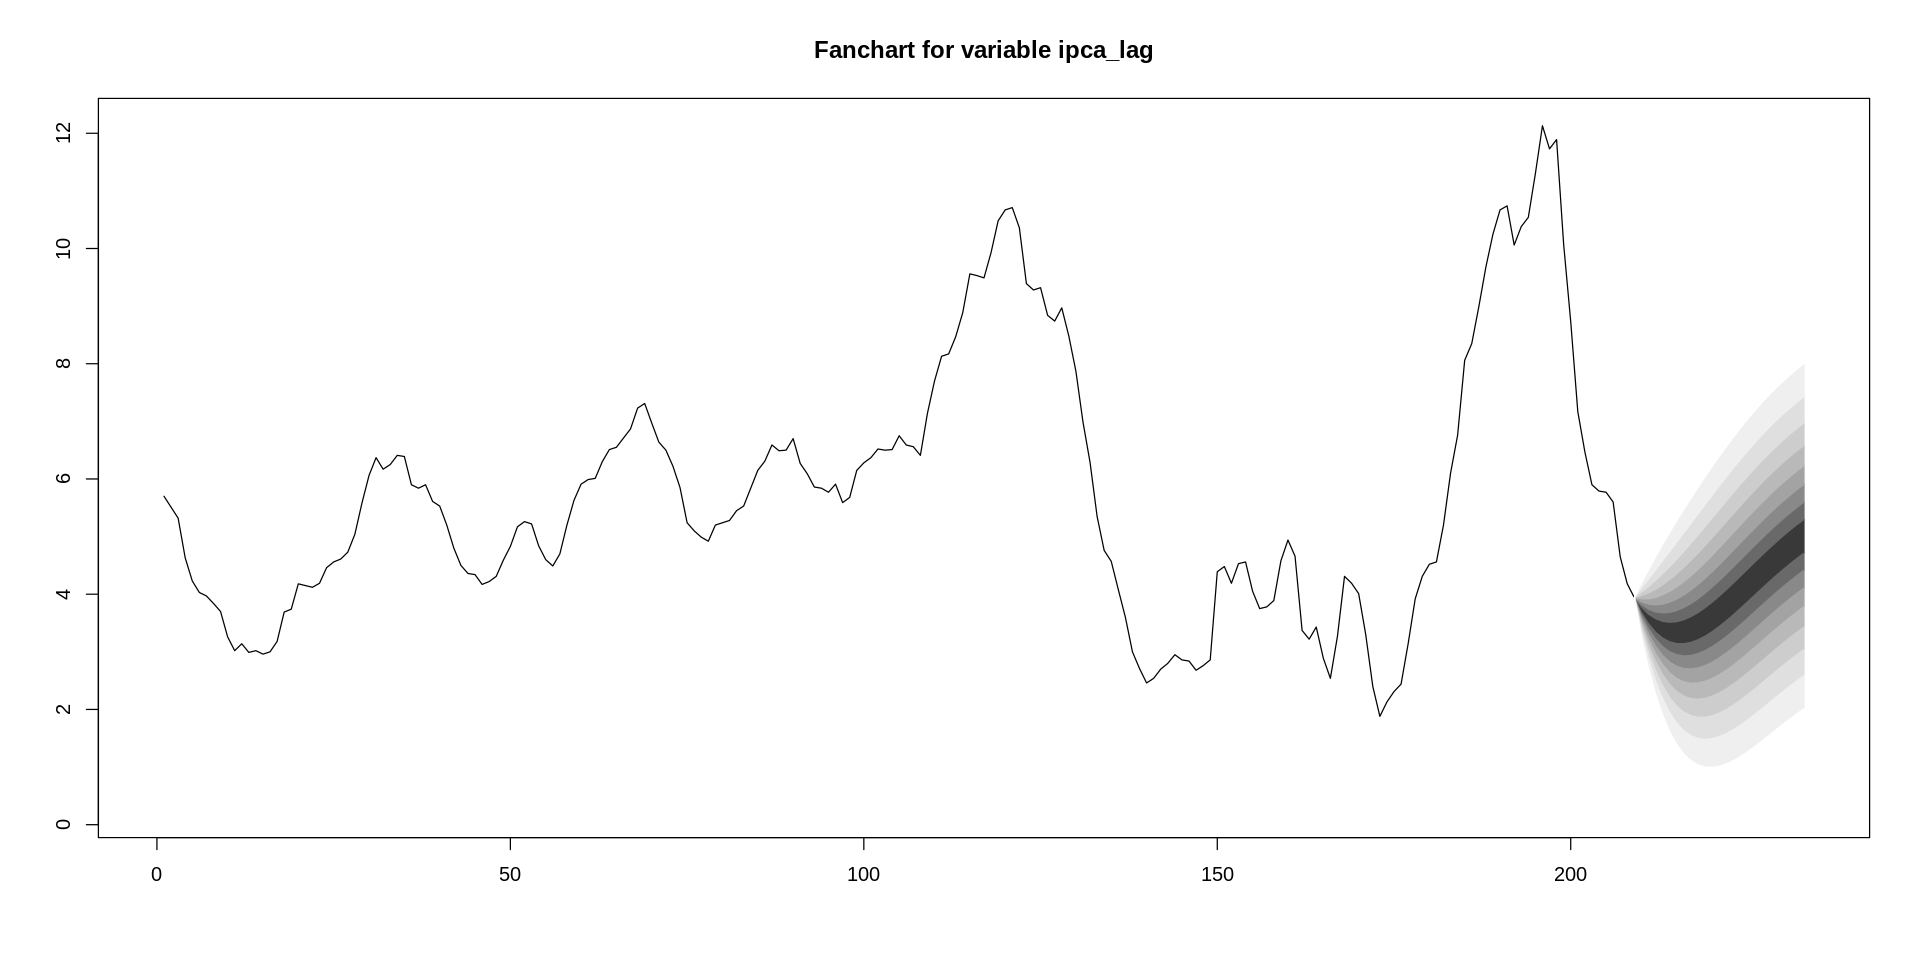

In [43]:
# Forecast using VAR
forecast_var <- predict(var_model, n.ahead = 24, ci = 0.95)

fanchart(forecast_var, names = "consumer_inflation_expectation")
fanchart(forecast_var, names = "ipca_lag")

### **Modelo VECM**

In [44]:
# Remover a primeira linha do dataframe com valores nulos
df_public_data_filtered <- df_public_data[-1, ]

# Ajuste as colunas de séries temporais de volta para o formato time series
df_public_data_filtered$consumer_inflation_expectation <- ts(df_public_data_filtered$consumer_inflation_expectation, start = c(2006, 3), frequency = 12)
df_public_data_filtered$ipca_lag <- ts(df_public_data_filtered$ipca_lag, start = c(2006, 3), frequency = 12)
df_public_data_filtered$selic_lag <- ts(df_public_data_filtered$selic_lag, start = c(2006, 3), frequency = 12)

# Selecionar variáveis do modelo VECM
vecm_model_variables <- df_public_data_filtered[, c("consumer_inflation_expectation", "ipca_lag", "selic_lag")]

In [45]:
# Lag Selection (n-1)
vecm_lag <- VARselect(vecm_model_variables, lag.max = 12, type = "none")

print(vecm_lag$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
     5      3      2      5 


In [46]:
# Johansen Test (Trace)
vecm_johansen_trace <- ca.jo(vecm_model_variables, type = "trace", ecdet = "none", K = 5)

summary(vecm_johansen_trace)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.12136781 0.06977028 0.03214744

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 2 |  6.67  6.50  8.18 11.65
r <= 1 | 21.42 15.66 17.95 23.52
r = 0  | 47.82 28.71 31.52 37.22

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                                  consumer_inflation_expectation.l5 ipca_lag.l5
consumer_inflation_expectation.l5                        1.00000000  1.00000000
ipca_lag.l5                                             -1.08703018 -0.44996919
selic_lag.l5                                            -0.07027601 -0.05849815
                                  selic_lag.l5
consumer_inflation_expectation.l5    1.0000000
ipca_lag.l5                          0.3906338
selic_lag.l5                        -1.1964202

Weights W:
(This is the loading matrix

**Resultado**

- r = 0: Como teststatistic é maior que critical value a um nível de significância de 5%, rejeita-se a hipótese nula, ou seja, existe ao menos 1 relação de cointegração no sistema

- r <= 1: Como teststatistic é maior que critical value a um nível de significância de 5%, rejeita-se a hipótese nula, ou seja, existe ao menos 2 relações de cointegração no sistema

- r <= 2: Como teststatistic é menor que critical value a um nível de significância de 5%, não se rejeita a hipótese nula, ou seja, existe no máximo 2 relações de cointegração no sistema

In [47]:
# Johansen Test (MaxEigen)
vecm_johansen_eigen <- ca.jo(vecm_model_variables, type = "eigen", ecdet = "none", K = 5)

summary(vecm_johansen_eigen)


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , with linear trend 

Eigenvalues (lambda):
[1] 0.12136781 0.06977028 0.03214744

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 2 |  6.67  6.50  8.18 11.65
r <= 1 | 14.75 12.91 14.90 19.19
r = 0  | 26.40 18.90 21.07 25.75

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                                  consumer_inflation_expectation.l5 ipca_lag.l5
consumer_inflation_expectation.l5                        1.00000000  1.00000000
ipca_lag.l5                                             -1.08703018 -0.44996919
selic_lag.l5                                            -0.07027601 -0.05849815
                                  selic_lag.l5
consumer_inflation_expectation.l5    1.0000000
ipca_lag.l5                          0.3906338
selic_lag.l5                        -1.1964202

Weights W:
(

**Resultado**

- r = 0: Como teststatistic é maior que critical value a um nível de significância de 5%, rejeita-se a hipótese nula, ou seja, existe ao menos 1 relação de cointegração no sistema

- r <= 1: Como teststatistic é menor que critical value a um nível de significância de 5%, não se rejeita a hipótese nula, ou seja, existe no máximo 1 relação de cointegração no sistema

In [48]:
# Criar modelo VECM
vecm_model <- VECM(vecm_model_variables, 5, r = 2, estim = ("ML"))

summary(vecm_model)

#############
###Model VECM 
#############
Full sample size: 209 	End sample size: 203
Number of variables: 3 	Number of estimated slope parameters 54
AIC -1566.172 	BIC -1380.632 	SSR 46.51965
Cointegrating vector (estimated by ML):
   consumer_inflation_expectation ipca_lag   selic_lag
r1                   1.000000e+00        0 -0.03331974
r2                   5.700589e-17        1  0.01108651


                                        ECT1                ECT2               
Equation consumer_inflation_expectation -0.1517(0.0438)***  0.1039(0.0352)**   
Equation ipca_lag                       -0.0128(0.0545)     -0.0690(0.0438)    
Equation selic_lag                      0.0221(0.0281)      -0.0075(0.0226)    
                                        Intercept          
Equation consumer_inflation_expectation 0.4016(0.1312)**   
Equation ipca_lag                       0.4870(0.1634)**   
Equation selic_lag                      -0.1056(0.0842)    
                                       

In [49]:
# VECM specification to VAR specification
vecm_model_formatted <- vec2var(vecm_johansen_trace, r = 2)

In [50]:
# Serial Correlation
vecm_serial_test <- serial.test(vecm_model_formatted, lags.pt = 12, type = "PT.asymptotic")

print(vecm_serial_test)


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 113.07, df = 66, p-value = 0.000278



$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 113.07, df = 66, p-value = 0.000278



**Resultado**

- Como o p-value é menor que um nível de significância de 5%, não se pode afirmar que as variáveis não possuem correlação serial

In [51]:
# Heteroscedasticity
vecm_arch_test <- arch.test(vecm_model_formatted, lags.multi = 12, multivariate.only = TRUE)

print(vecm_arch_test)


	ARCH (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 526.43, df = 432, p-value = 0.001236



$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 526.43, df = 432, p-value = 0.001236



**Resultado**

- Como o p-value é menor que um nível de significância de 5%, não se pode afirmar que o modelo não possui heteroscedasticidade

In [52]:
# Normal Distribution of Residuals
vecm_normal_test <- normality.test(vecm_model_formatted, multivariate.only = TRUE)

print(vecm_normal_test)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 125.44, df = 6, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 8.5504, df = 3, p-value = 0.03591


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 116.89, df = 3, p-value < 2.2e-16




$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 125.44, df = 6, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 8.5504, df = 3, p-value = 0.03591


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 116.89, df = 3, p-value < 2.2e-16




**Resultado**

- Como o p-value é menor que um nível de significância de 5% no JB-test, não se pode afirmar que os resíduos são distribuídos de forma gaussiana

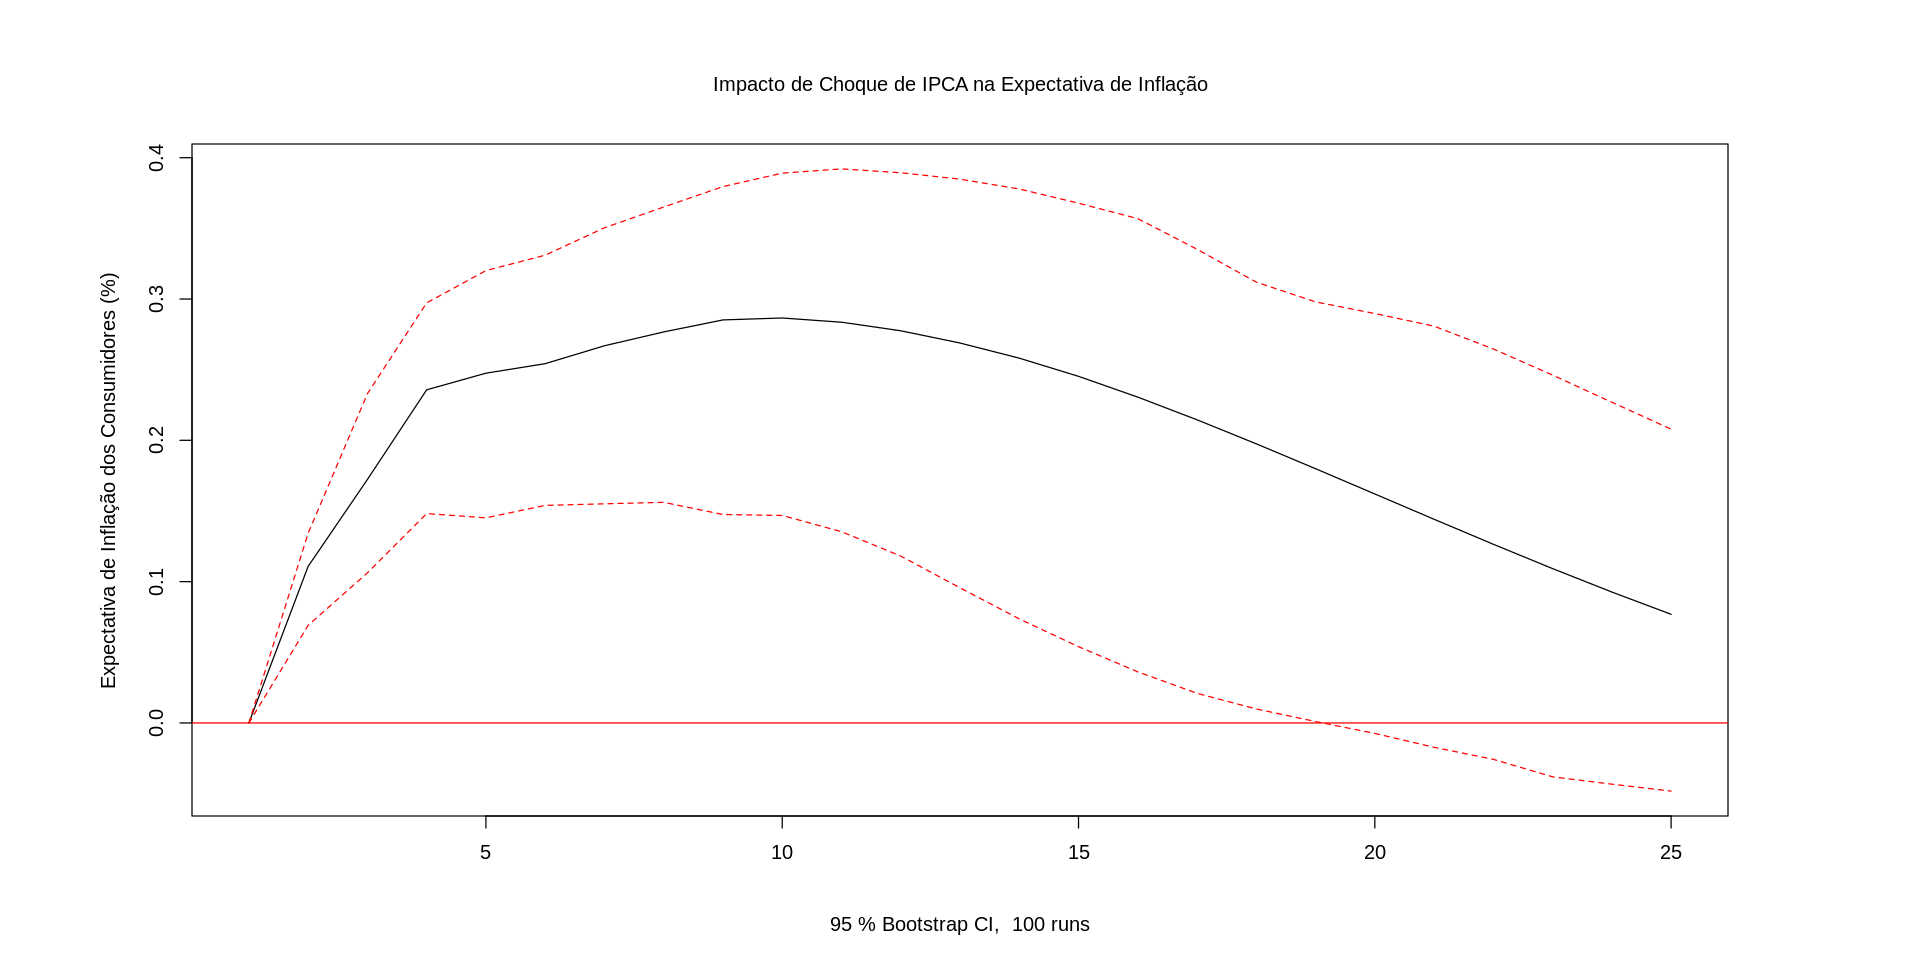

In [53]:
# Impulse Response Function
vecm_ipca_consumer_expectation_impulse = irf(vecm_model_formatted, impulse = "ipca_lag", response = "consumer_inflation_expectation", n.ahead = 24, boot = TRUE)

plot(vecm_ipca_consumer_expectation_impulse, ylab = "Expectativa de Inflação dos Consumidores (%)", main = "Impacto de Choque de IPCA na Expectativa de Inflação")

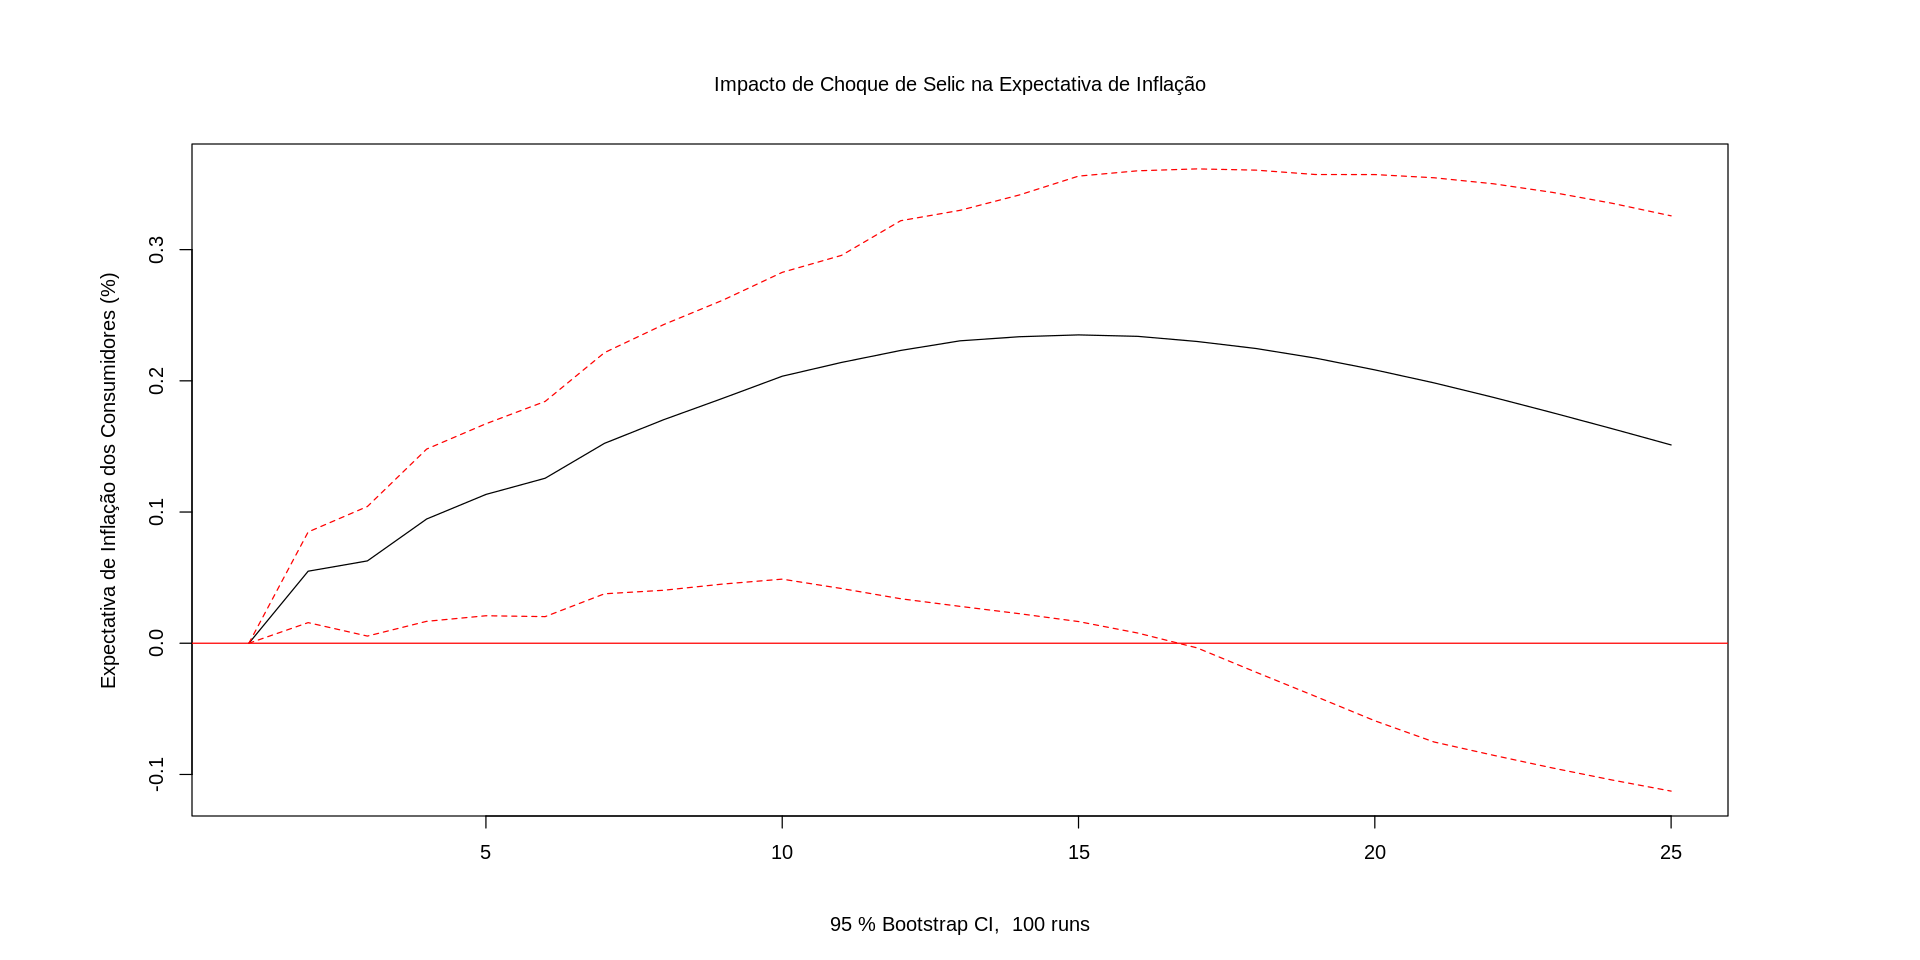

In [54]:
# Impulse Response Function
vecm_selic_consumer_expectation_impulse = irf(vecm_model_formatted, impulse = "selic_lag", response = "consumer_inflation_expectation", n.ahead = 24, boot = TRUE)

plot(vecm_selic_consumer_expectation_impulse, ylab = "Expectativa de Inflação dos Consumidores (%)", main = "Impacto de Choque de Selic na Expectativa de Inflação")

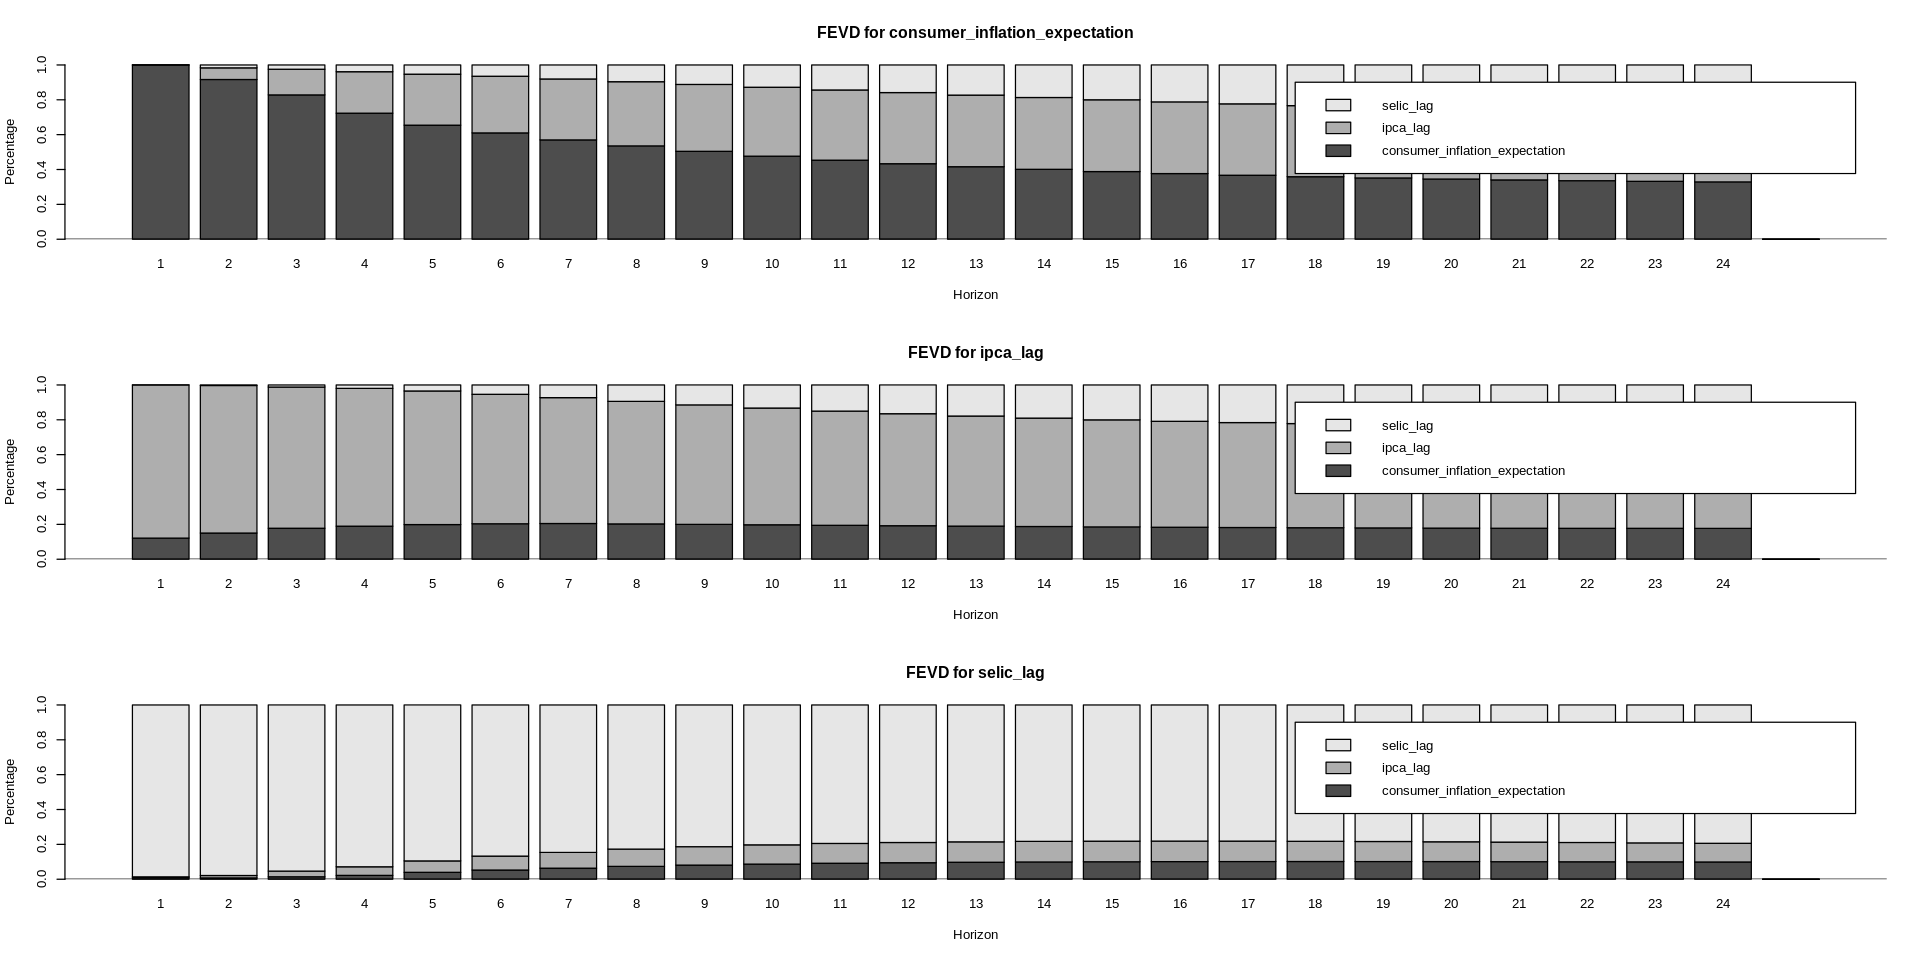

In [55]:
# Variance Decomposition
vecm_fevd <- fevd(vecm_model_formatted, n.ahead = 24)

plot(vecm_fevd)

**Resultado**

- Depois de ~9 meses, a Expectativa de Inflação dos Consumidores é mais explicada pelo IPCA e Selic do que a própria Expectativa de Inflação dos Consumidores

- As variáveis Selic e IPCA são, em sua maioria, explicadas por elas mesmas

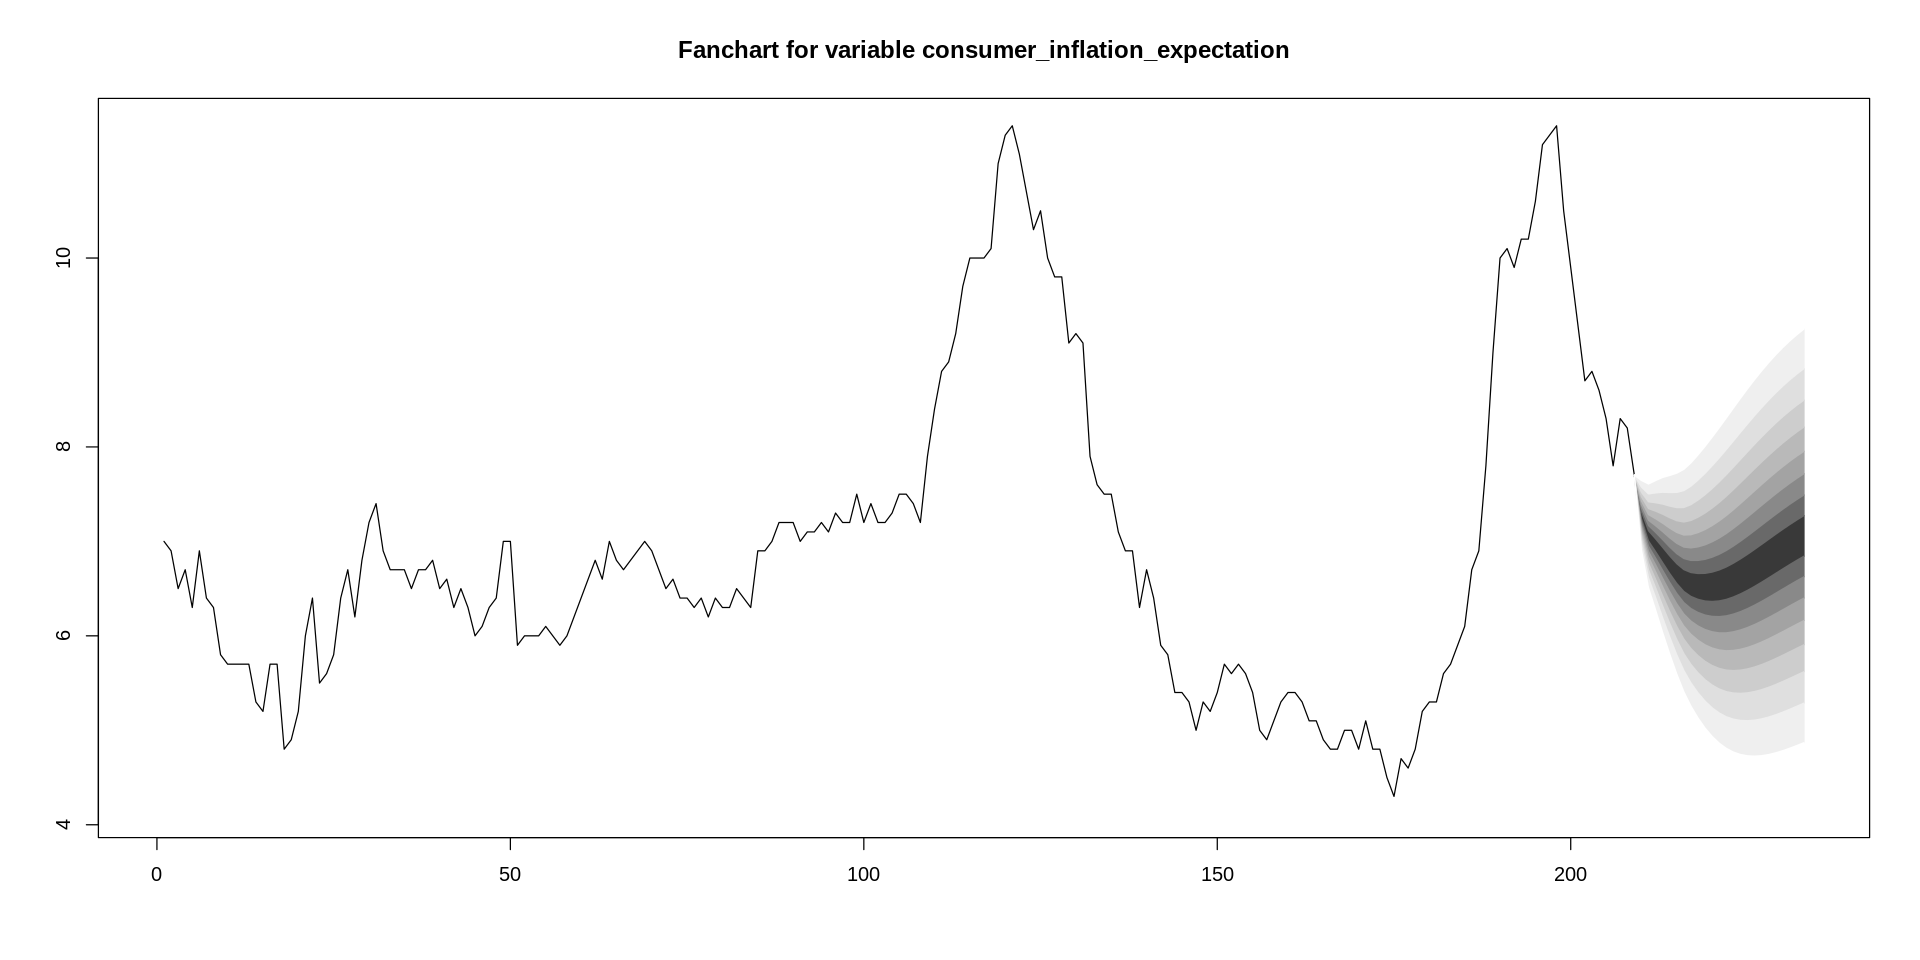

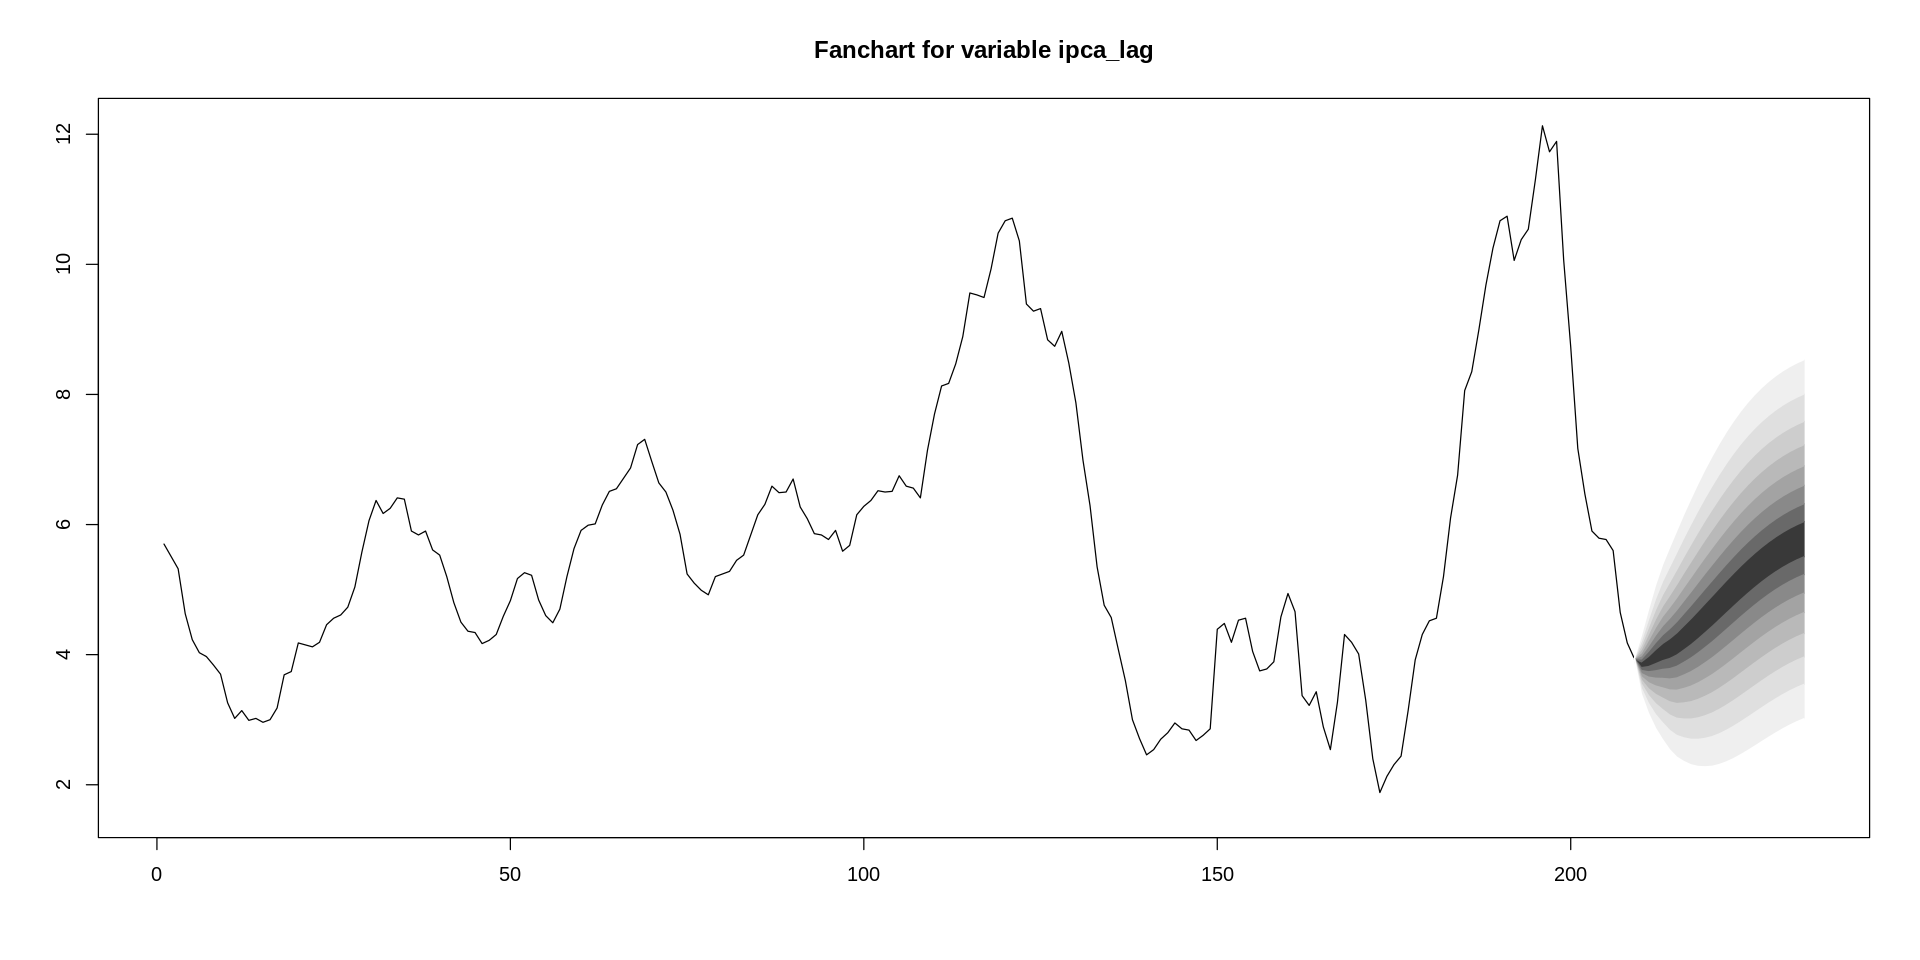

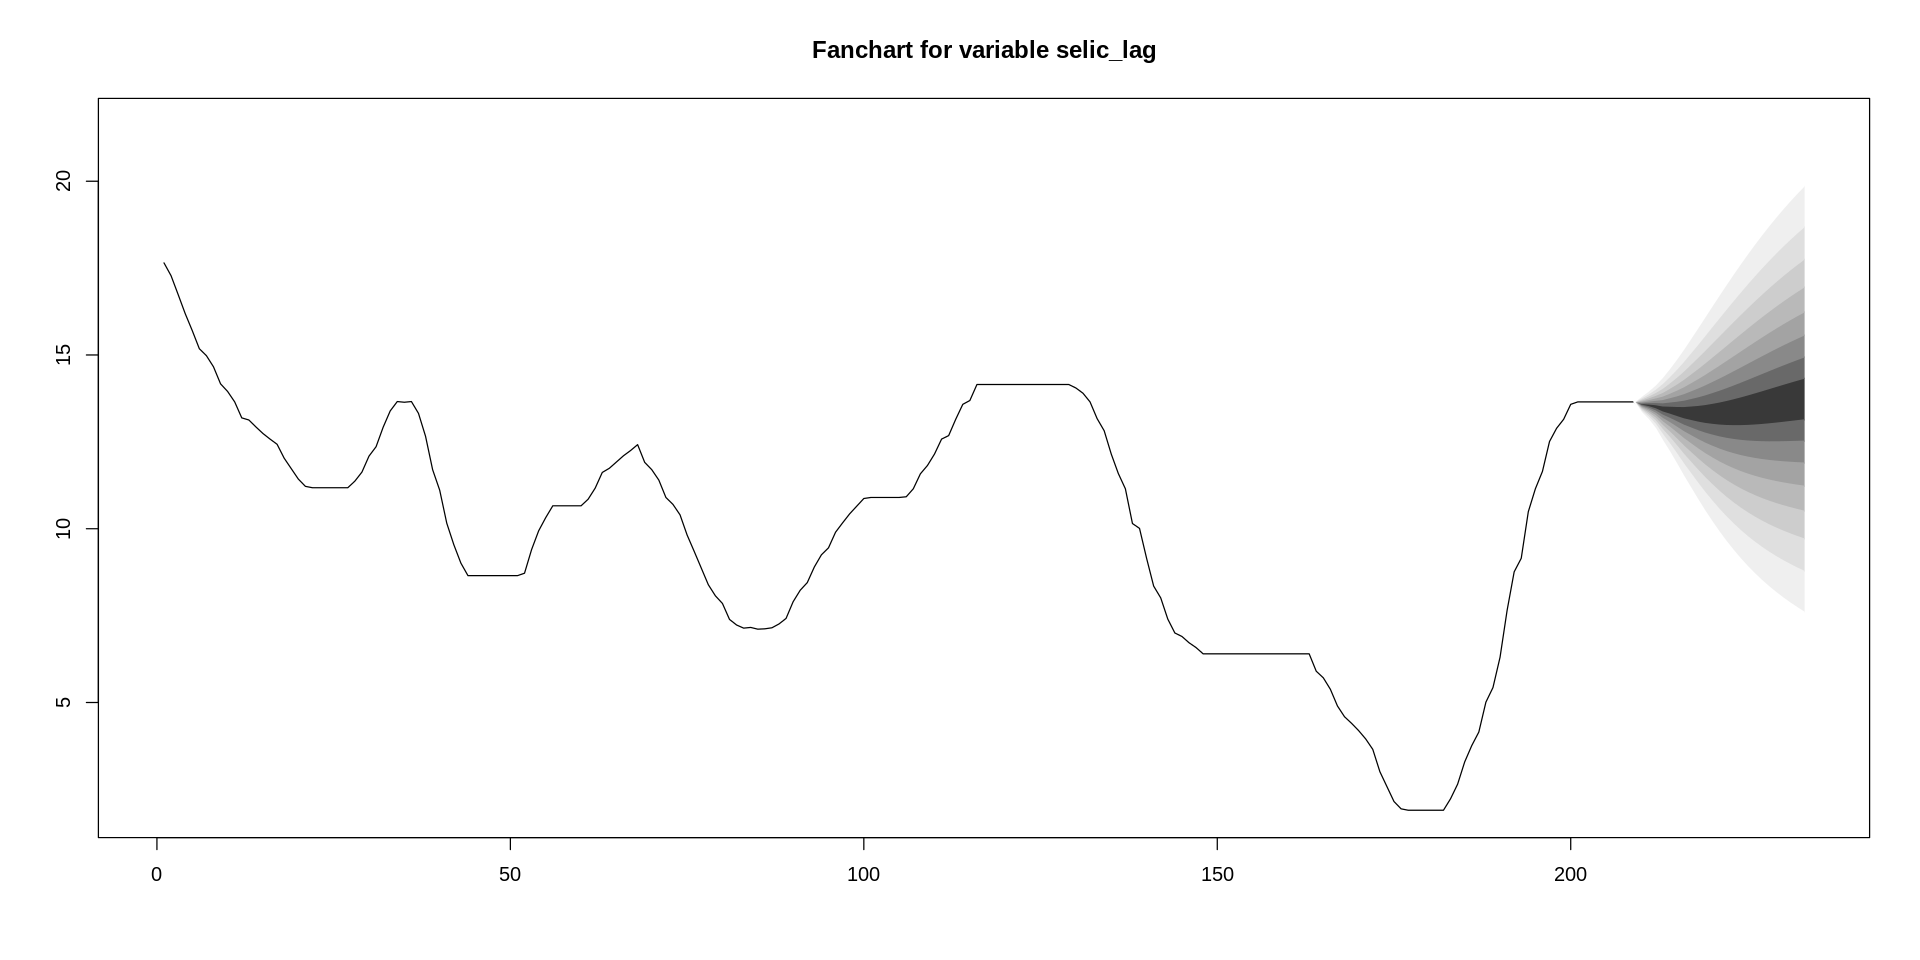

In [56]:
# Forecast using VECM
forecast_vecm <- predict(vecm_model_formatted, n.ahead = 24, ci = 0.95)

fanchart(forecast_vecm, names = "consumer_inflation_expectation")
fanchart(forecast_vecm, names = "ipca_lag")
fanchart(forecast_vecm, names = "selic_lag")